In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from numba import jit
from scipy.stats import zscore
from scipy.stats import ks_1samp
from scipy.stats import norm, kstest
from scipy.optimize import minimize
from scipy.spatial import distance
from scipy.integrate import quad
from scipy.stats import kstest
import random
from sklearn.cluster import DBSCAN
from collections import Counter
from scipy.stats import ttest_ind
from scipy.stats import ks_2samp

In [2]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
# rc('text', usetex=True)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.rcParams['font.size']=15
plt.rcParams['pdf.fonttype']=42
plt.rcParams["text.usetex"]=False

### Defining a constant that will be used throughout the analysis

In [3]:
micron_per_pixel = 1.0/23.5 # Value from Salman

# Functions defining different distributions

### 1. Lifschitz-Slyozov-Wagner distribution for coarsening through ripening

In [28]:
@jit
def lsw(rmin, rmax, mean, dr=0.01):
    """Function to compute the probability density according to the Lifschitz-Wagner-Slyozov distribution for coarsening"""
    r = np.arange(rmin, 1.5*mean, dr)
    c_lsw = np.cumsum((1.0/mean)*(4/9)*(r/mean)**2 *(1 + r/(3*mean))**(-7/3)*
                        (1 - (2*r)/(3*mean))**(-11/3)*np.exp((2*r)/(3*mean)/((2*r)/(3*mean) - 1)))
    # Normalize the CDF to 1
    c_lsw = c_lsw/np.max(c_lsw)
    
    # LSW CDF reaches the value of 1 at 1.5*mean and doesn't change after that. 
    if rmax > 1.5*mean:
        r_extended = np.arange(1.5*mean, rmax, dr)
        r = np.append(r, r_extended)
        c_lsw = np.append(c_lsw, np.ones(len(r_extended)))
        
    return r, c_lsw

In [29]:
def lsw_cdf(r, rmin, rmax, mean, dr):
    """Calculate the cumulative distribution function from the lsw distribution for a particular value of r"""
    cdf = np.zeros(len(r))
    for i in range(len(r)):
        rmax = np.min([rmax, 1.5*mean])
        r_range = np.arange(rmin, rmax, dr)
        pdf = (1.0/mean)*(4/9)*(r_range/mean)**2 *(1 + r_range/(3*mean))**(-7/3)*(1 - (2*r_range)/(3*mean))**(-11/3)*np.exp((2*r_range)/(3*mean)/((2*r_range)/(3*mean) - 1))
        cdf[i] = np.sum(pdf[r_range < r[i]])/np.sum(pdf)
    return cdf

Helper functions to fit the LSW distribution to data

In [30]:
def lsw_error(params, cutoff, data, rmax, dr):
    """Objective function to minimize to fit the lsw distribution to data"""
    cdf = lambda x: lsw_cdf(r=x, rmin=cutoff, rmax=rmax, mean=params, dr=dr)
    ks = ks_1samp(data, cdf)
    return ks.statistic

def fit_lsw(cutoff, data, rmax, mean_guess, dr=0.01):
    """Fit the LSW distribution to data using Kolmogorov-Smirnov distance as an optimizing metric"""
    optimum = minimize(lsw_error, mean_guess, args=(cutoff, data, rmax, dr), bounds=[(0.0, rmax)], method='Nelder-Mead')
    return optimum

### 2. Normal distribution for particles having a typical size

In [31]:
@jit
def normal(rmin, rmax, mean, sigma, dr=0.01):
    """Function to compute the probability density according to the normal distribution"""
    r = np.arange(rmin, rmax, dr)
    c_normal = np.cumsum(1.0/(sigma*(2*np.pi)**0.5)*np.exp(-(r - mean)**2/(2*sigma**2)))
    # Normalize the CDF to 1
    c_normal = c_normal/c_normal[-1]
    return r, c_normal

In [32]:
def normal_cdf(r, rmin, rmax, mean, sigma, dr):
    """Calculate the cumulative distribution function from the normal distribution for a particular value of r"""
    cdf = np.zeros(len(r))
    for i in range(len(r)):
        r_range = np.arange(rmin, rmax, dr)
        pdf = 1.0/(sigma*(2*np.pi)**0.5)*np.exp(-(r_range - mean)**2/(2*sigma**2))
        cdf[i] = np.sum(pdf[r_range < r[i]])/np.sum(pdf)
    return cdf

Helper functions to fit data to a normal distribution

In [33]:
def normal_error(params, cutoff, data, rmax, dr):
    """Objective function to minimize to fit the lsw distribution to data"""
    cdf = lambda x: normal_cdf(r=x, rmin=cutoff, rmax=rmax, mean=params[0], sigma=params[1], dr=dr)
    ks = ks_1samp(data, cdf)
    return ks.statistic

def fit_normal(cutoff, data, rmax, params_guess, dr=0.01):
    """Fit the LSW distribution to data using Kolmogorov-Smirnov distance as an optimizing metric"""
    optimum = minimize(normal_error, params_guess, args=(cutoff, data, rmax, dr), bounds=[(0.0, rmax), (0.0, rmax)], method='Nelder-Mead')
    return optimum

### 3. Log normal distribution

In [34]:
@jit
def lognormal(rmin, rmax, log_mean, log_sigma, dr=0.01):
    """Function to compute the probability density according to the log normal distribution"""
    r = np.arange(rmin, rmax, dr)
    c_log_normal = np.cumsum(1.0/(r*log_sigma*(2*np.pi)**0.5)*np.exp(-(np.log(r) - log_mean)**2/(2*log_sigma**2))) 
    # Normalize the CDF to 1
    c_log_normal = c_log_normal/c_log_normal[-1]
    return r, c_log_normal

In [35]:
def log_normal_cdf(r, rmin, rmax, exp_log_mean, exp_log_sigma, dr):
    """Calculate the cumulative distribution function from the lsw distribution for a particular value of r"""
    cdf = np.zeros(len(r))
    r_range = np.arange(rmin, rmax, dr)
    pdf = (1.0/(r_range*np.log(exp_log_sigma)*(2*np.pi)**0.5)*
           np.exp(-(np.log(r_range) - np.log(exp_log_mean))**2/(2*np.log(exp_log_sigma)**2)))
    for i in range(len(r)):
        cdf[i] = np.sum(pdf[r_range < r[i]])/np.sum(pdf)
    return cdf

Helper functions to fit data to a log normal distribution

In [36]:
def log_normal_error(params, cutoff, data, rmax, dr):
    """Objective function to minimize to fit the lsw distribution to data"""
    cdf = lambda x: log_normal_cdf(r=x, rmin=cutoff, rmax=rmax, exp_log_mean=params[0], exp_log_sigma=params[1], dr=dr)
    ks = ks_1samp(data, cdf)
    return ks.statistic

def fit_log_normal(cutoff, data, rmax, params_guess, dr=0.01):
    """Fit the LSW distribution to data using Kolmogorov-Smirnov distance as an optimizing metric"""
    optimum = minimize(log_normal_error, params_guess, args=(cutoff, data, rmax, dr), bounds=[(cutoff, rmax), (0.0, rmax)], method='Nelder-Mead')
    return optimum

## Different methods of fitting distributions to data

### 1. Parameter free method by using the mean and variance estimated from the data

In [37]:
def fit_distributions_parameter_free(data, condition):
    """Function to fit the three different distributions given the data in a parameter free way 
    and plot the fit cumulative distributions to assess the fit"""
    
    mean = np.mean(data)
    sigma = np.std(data)
    log_mean = np.mean(np.log(data))
    log_sigma = np.std(np.log(data))
    rmin = np.min(data)
    rmax = np.max(data)
    
    fig, axs = plt.subplots(1,1)
    
    # Plot cumulative distribution of data
    axs.hist(data*micron_per_pixel, bins=200, density=True, cumulative=True)
    
    # Calculate the cumulative distribution from the estimated means and standard deviations
    r_lsw, c_lsw = lsw(rmin, rmax, mean)
    r_normal, c_normal = normal(rmin, rmax, mean, sigma)
    r_log_normal, c_log_normal = lognormal(rmin, rmax, log_mean, log_sigma)
    
    axs.plot(r_lsw*micron_per_pixel, c_lsw, label='LSW', c='r')
    axs.plot(r_normal*micron_per_pixel, c_normal, label='Normal', c='k')
    axs.plot(r_log_normal*micron_per_pixel, c_log_normal, label='Log Normal', c='m')
    axs.set_xlabel(r'Droplet radius ($\mu$m)')
    axs.set_ylabel(r'Cumulative distribution function')
    plt.legend()
    plt.title(condition)
    plt.show()
    plt.close()

In [38]:
def fit_distributions_and_return_stats(data, condition, flag=0):
	"""Function to fit the three different distributions given the data to distributions with parameters
	that describe them including the mean and the variance, also taking into account the minimum size thresholds.
	This plots the fit cumulative distributions to assess the fit, and also returns the fitting statistics
	
	NOTE: When supplying distances, supply them in pixel values and NOT in microns
	"""
	mean = np.mean(data)
	sigma = np.std(data) 
	exp_log_mean = np.exp(np.mean(np.log(data)))
	exp_log_sigma = np.exp(np.std(np.log(data)))
	rmin = np.min(data)
	rmax = np.max(data)

	if flag:
		fig, axs = plt.subplots(1,1)
		axs.hist(data*micron_per_pixel, bins=200, density=True, cumulative=True, color='g', alpha=0.6)
    
	# Fit the three distributions to data
	
	best_lsw = fit_lsw(cutoff=rmin, data=data, rmax=rmax, mean_guess=mean)
	r_lsw, c_lsw = lsw(rmin, rmax, best_lsw.x[0])
	
	best_normal = fit_normal(cutoff=rmin, data=data, rmax=rmax, params_guess=[mean, sigma])
	r_normal, c_normal = normal(rmin, rmax, best_normal.x[0], best_normal.x[1])
	
	best_log_normal = fit_log_normal(cutoff=rmin, data=data, rmax=rmax, params_guess=[exp_log_mean, exp_log_sigma])
	r_log_normal, c_log_normal = lognormal(rmin, rmax, np.log(best_log_normal.x[0]), np.log(best_log_normal.x[1]))
	if flag:
		print(condition)
		print('Best LSW:', best_lsw.fun, 'Best Normal:', best_normal.fun, 'Best Log Normal:', best_log_normal.fun)
		print('Mean size:', best_normal.x[0])
	
	# Get p-values
	
	best_lsw_cdf = lambda x: lsw_cdf(r=x, rmin=rmin, rmax=rmax, mean=best_lsw.x[0], dr=0.01)
	best_lsw_pvalue = kstest(data, best_lsw_cdf)
	
	best_normal_cdf = lambda x: normal_cdf(r=x, rmin=rmin, rmax=rmax, mean=best_normal.x[0], 
                                           sigma=best_normal.x[1], dr=0.01)
	best_normal_pvalue = kstest(data, best_normal_cdf)
	
	best_log_normal_cdf = lambda x: log_normal_cdf(r=x, rmin=rmin, rmax=rmax, exp_log_mean=best_log_normal.x[0],
                                                   exp_log_sigma=best_log_normal.x[1], dr=0.01)
	best_log_normal_pvalue = kstest(data, best_log_normal_cdf)
    
	if flag:
		print('pvalue LSW:', best_lsw_pvalue, 'pvalue Normal:', 
				best_normal_pvalue, 'pvalue Log Normal:', best_log_normal_pvalue)
	fitting_stats = [condition, best_lsw.fun, best_lsw_pvalue.pvalue, best_lsw.x[0]*micron_per_pixel, 
					 best_normal.fun,
					 best_normal_pvalue.pvalue, best_normal.x[0]*micron_per_pixel, best_normal.x[1]*micron_per_pixel, 
					 best_log_normal.fun, best_log_normal_pvalue.pvalue, best_log_normal.x[0]*micron_per_pixel, 
					 best_log_normal.x[1]*micron_per_pixel] # Log normal
	if flag: 
		axs.plot(r_lsw*micron_per_pixel, c_lsw, label='LSW', c='k', linestyle='--')
		axs.plot(r_normal*micron_per_pixel, c_normal, label='Normal', c='k')
		axs.plot(r_log_normal*micron_per_pixel, c_log_normal, label='Log Normal', c='k', linestyle=':')

		axs.set_xlabel(r'Droplet radius ($\mu$m)')
		axs.set_ylabel(r'Cumulative distribution function')
		plt.legend()

		plt.title(condition)
		plt.savefig('Figures_for_paper/' + condition + '_fitting_droplet_size_distribution.svg', format='svg', dpi=600)
		plt.savefig('Figures_for_paper/' + condition + '_fitting_droplet_size_distribution.pdf', format='pdf', dpi=600)
		plt.show()
		plt.close()
	
	return fitting_stats

# Analysis of fed-starved cells

In [563]:
dataset = pd.read_csv('Data/feeding_starvation_data.csv')
dataset['radius'] = np.divide(dataset['pixels'], np.pi)**0.5
dataset['radius (microns)'] = dataset['radius']*micron_per_pixel
dataset['sample_type'] = [val[0].capitalize() for val in dataset['sample'].str.split('-')]
dataset.head()

,sample,spot_id,pixels,mean_intensity,centroid_r,centroid_c,radius,radius (microns),sample_type
0,fed-01,1,30,0.242753,5,347,3.090194,0.131498,Fed
1,fed-01,2,35,0.284423,12,340,3.337791,0.142034,Fed
2,fed-01,3,57,0.341507,15,375,4.259538,0.181257,Fed
3,fed-01,4,62,0.333472,22,360,4.442433,0.189040,Fed
4,fed-01,5,23,0.223350,24,385,2.705758,0.115139,Fed


### Violin plot of condensate sizes and statistical significance of the difference in mean

/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Ttest_indResult(statistic=20.275240249518056, pvalue=1.084779598540874e-78)
0.37476107509383233
0.28579762388926566
0.11588624929184432
0.07131311803002435


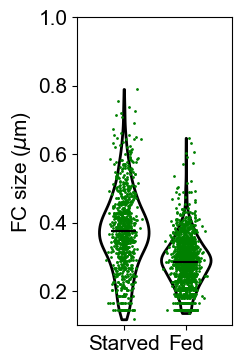

In [564]:
# Plot violin plot of the data

fig, axs = plt.subplots(1, 1, figsize=(2,4))

# Segment the dataset by condition
data = 2.0*np.array([dataset[dataset['sample_type'] == 'Starved']['radius (microns)'], 
                     dataset[dataset['sample_type'] == 'Fed']['radius (microns)']])

# Plot violinplot
parts = axs.violinplot(data, vert=True, widths=0.8, showmeans=True, showextrema=False)

parts['cmeans'].set_color(['k']*len(data))
for pc in parts['bodies']:
    pc.set_facecolor('white')
    pc.set_edgecolor('black')
    pc.set_alpha(1.0)
    pc.set_linewidth(2.0)
    
# Set the x labels for the plot
def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
labels = ['Starved', 'Fed']
set_axis_style(axs, labels)

# Plot the scatter plot of data
y_list = []
i = 0
for condition in ['Starved', 'Fed']:
    # condition = dataset['sample_type'].unique()[i]
    y = 2.0*dataset[dataset['sample_type'] == condition]['radius (microns)'].dropna()
    y_list.append(y)
    # Add some random "jitter" to the x-axis
    x = np.random.normal(i+1, 0.1, size=len(y))
    axs.scatter(x, y, color='green', marker='o', alpha=1.0, s=1.0)
    i = i+1

axs.set_ylabel(r'FC size ($\mu$m)')
axs.set_ylim([0.1, 1.0])

plt.savefig('Figures_for_paper/Violin_droplet_size_fed_starved.svg', format='svg', dpi=600)
plt.savefig('Figures_for_paper/Violin_droplet_size_fed_starved.pdf', format='pdf', dpi=600)

print(ttest_ind(y_list[0], y_list[1], equal_var=False))

print(np.mean(y_list[0]))
print(np.mean(y_list[1]))

print(np.std(y_list[0]))
print(np.std(y_list[1]))

### (Ignore for now) Fitting parameter-free models for the probability distributions of droplet sizes

In [ ]:
for condition in dataset['sample_type'].unique():
    
    fit_distributions_parameter_free(dataset[dataset['sample_type'] == condition]['radius'], condition)

### Getting best fit models of the probability distributions of droplet sizes by fitting mean and variance

/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Fed
Best LSW: 0.0906556125615352 Best Normal: 0.03241571791462525 Best Log Normal: 0.04685077611106544
Mean size: 3.3319655381041855
pvalue LSW: KstestResult(statistic=0.0906556125615352, pvalue=9.961608384290997e-12) pvalue Normal: KstestResult(statistic=0.03241571791462525, pvalue=0.07114916288291129) pvalue Log Normal: KstestResult(statistic=0.04685077611106544, pvalue=0.0019045200925720822)


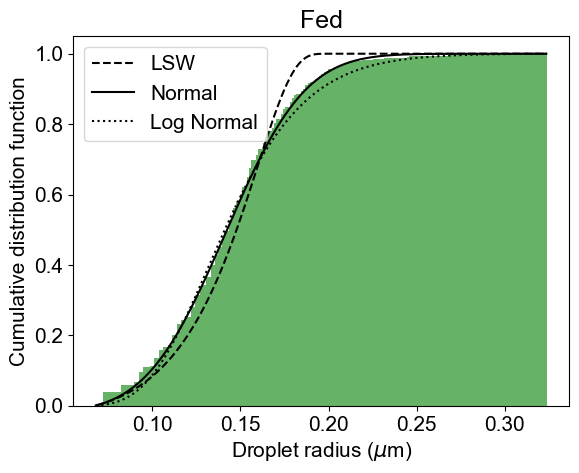

/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Starved
Best LSW: 0.12166831229687786 Best Normal: 0.029422752470471103 Best Log Normal: 0.048459992495365464
Mean size: 4.357839332191223
pvalue LSW: KstestResult(statistic=0.12166831229687786, pvalue=2.786089248129276e-11) pvalue Normal: KstestResult(statistic=0.029422752470471103, pvalue=0.45333933841614726) pvalue Log Normal: KstestResult(statistic=0.048459992495365464, pvalue=0.03759947176311884)


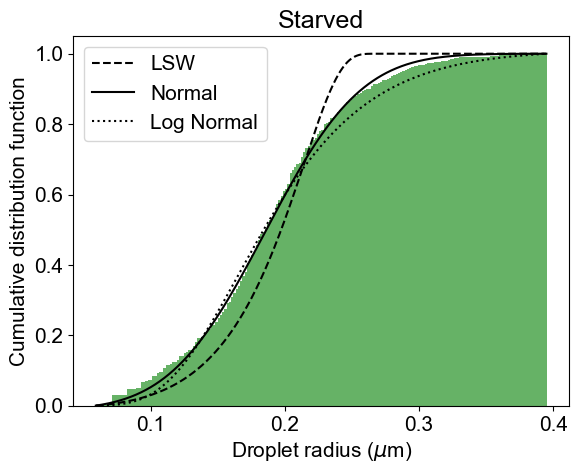

In [28]:
fitting_stats = pd.DataFrame(columns=['Condition',
                                      'KS_Best_LSW', 'pvalue_Best_LSW', 'Mean_Best_LSW (microns)', # LSW
                                      'KS_Best_Normal', 'pvalue_Best_Normal', 'Mean_Best_Normal (microns)',
                                      'Std_Best_Normal (microns)', # Normal
                                      'KS_Best_Log_Normal', 'pvalue_Best_Log_Normal', 
                                      'Log_Mean_Best_Log_Normal (microns)',
                                      'Log_Std_Best_Log_Normal (microns)'] # Log normal
                            )

for condition in dataset['sample_type'].unique():
    
    # data = dataset[dataset['sample_type'] == condition]['radius']
    data = dataset[(dataset['sample_type'] == condition)*(dataset['radius'] > 1.0)]['radius']
    fitting_stats_list = fit_distributions_and_return_stats(data, condition, flag=1)
    fitting_stats.loc[len(fitting_stats)] = fitting_stats_list
    
fitting_stats.to_csv('Fitting_statistics_size_distbn_fed_starved.csv')

**Note:** A normal distribution fits the droplet size distribution, when not controlling for cell size. Therefore, we are going to fit the Gaussian functional form to fit the overall data and get the average droplet size and variance of the droplet size

### Checking how the fit parameters change with using different cutoffs for normal distribution

In [23]:
# Check the whether the fit mean and standard deviation change if we take different amounts of data

cutoff_values = np.linspace(1.2, 3.2, 20)
mean_guess = {'Fed': 0.15/micron_per_pixel, 'Starved': 0.19/micron_per_pixel}

mean_dict = {'Fed': [], 'Starved': []}
sigma_dict = {'Fed': [], 'Starved': []}
pvalue_dict = {'Fed': [], 'Starved': []}

for i in range(len(cutoff_values)):
    print(i)
    for condition in dataset['sample_type'].unique():
        data = dataset[(dataset['sample_type'] == condition)*
                       (dataset['radius'] > cutoff_values[i])]['radius']
        rmax = np.max(data)
        mean = mean_guess[condition]
        sigma = np.std(data)
        best_normal = fit_normal(cutoff=cutoff_values[i], data=data, rmax=rmax, params_guess=[mean, sigma])
        r_normal, c_normal = normal(cutoff_values[i], rmax, best_normal.x[0], best_normal.x[1])
        best_normal_cdf = lambda x: normal_cdf(r=x, rmin=cutoff_values[i], rmax=rmax, mean=best_normal.x[0], 
                                           sigma=best_normal.x[1], dr=0.01)
        best_normal_pvalue = kstest(data, best_normal_cdf)
        pvalue_dict[condition].append(best_normal_pvalue)
        mean_dict[condition].append(best_normal.x[0])
        sigma_dict[condition].append(best_normal.x[1])
        print(condition, ': ', cutoff_values[i], ',  pvalue: ', best_normal_pvalue)
        
        
cutoff_values_microns = np.array(cutoff_values)*micron_per_pixel
mean_dict['Fed'] = np.array(mean_dict['Fed'])*micron_per_pixel
mean_dict['Starved'] = np.array(mean_dict['Starved'])*micron_per_pixel
sigma_dict['Fed'] = np.array(sigma_dict['Fed'])*micron_per_pixel
sigma_dict['Starved'] = np.array(sigma_dict['Starved'])*micron_per_pixel

0
Fed :  1.2 ,  pvalue:  KstestResult(statistic=0.030219336430438365, pvalue=0.10996355917036782)
Starved :  1.2 ,  pvalue:  KstestResult(statistic=0.028478495019489264, pvalue=0.4952811280980097)
1
Fed :  1.305263157894737 ,  pvalue:  KstestResult(statistic=0.028423067877443753, pvalue=0.15345039018073692)
Starved :  1.305263157894737 ,  pvalue:  KstestResult(statistic=0.029135606720897385, pvalue=0.46589785935506434)
2
Fed :  1.4105263157894736 ,  pvalue:  KstestResult(statistic=0.030750483135792095, pvalue=0.09925296257347827)
Starved :  1.4105263157894736 ,  pvalue:  KstestResult(statistic=0.029267865230314993, pvalue=0.46085012497832123)
3
Fed :  1.5157894736842104 ,  pvalue:  KstestResult(statistic=0.029609355379084115, pvalue=0.1234233391687668)
Starved :  1.5157894736842104 ,  pvalue:  KstestResult(statistic=0.030927372806100778, pvalue=0.3913495558397144)
4
Fed :  1.6210526315789473 ,  pvalue:  KstestResult(statistic=0.03311387643266735, pvalue=0.06169344283731848)
Starved :  

Fed: Mean =  0.14470471392291992  (um), Std. dev =  0.031584583850300496
Starved: Mean =  0.1878808353919403  (um), Std. dev =  0.05386528270208939


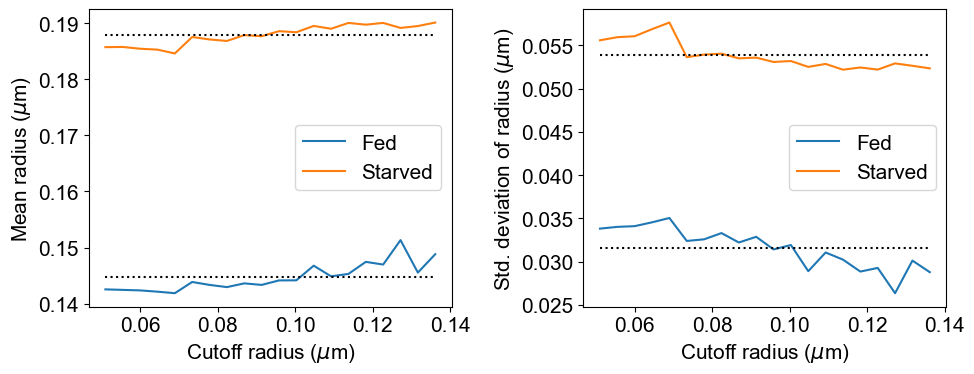

In [24]:
# Plot the above results

print('Fed: Mean = ', str(np.mean(mean_dict['Fed'])), ' (um), Std. dev = ', str(np.mean(sigma_dict['Fed'])))
print('Starved: Mean = ', str(np.mean(mean_dict['Starved'])), ' (um), Std. dev = ', str(np.mean(sigma_dict['Starved'])))

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(cutoff_values_microns, mean_dict['Fed'], label='Fed')
axs[0].plot(cutoff_values_microns, mean_dict['Starved'], label='Starved')
axs[0].plot(cutoff_values_microns, np.mean(mean_dict['Starved'])*np.ones(len(cutoff_values_microns)), 
            linestyle=':', c='k')
axs[0].plot(cutoff_values_microns, np.mean(mean_dict['Fed'])*np.ones(len(cutoff_values_microns)), 
            linestyle=':', c='k')
axs[0].set_ylabel('Mean radius ($\mu$m)')
axs[0].set_xlabel('Cutoff radius ($\mu$m)')
axs[0].legend()

axs[1].plot(cutoff_values_microns, sigma_dict['Fed'], label='Fed')
axs[1].plot(cutoff_values_microns, sigma_dict['Starved'], label='Starved')
axs[1].plot(cutoff_values_microns, np.mean(sigma_dict['Starved'])*np.ones(len(cutoff_values_microns)), 
            linestyle=':', c='k')
axs[1].plot(cutoff_values_microns, np.mean(sigma_dict['Fed'])*np.ones(len(cutoff_values_microns)), linestyle=':',
           c='k')
axs[1].set_ylabel('Std. deviation of radius ($\mu$m)')
axs[1].set_xlabel('Cutoff radius ($\mu$m)')
axs[1].legend()
fig.tight_layout()

plt.savefig('Figures_for_paper/Vary_cutoff_size_fed_starved.svg', format='svg', dpi=600)
plt.savefig('Figures_for_paper/Vary_cutoff_size_fed_starved.pdf', format='pdf', dpi=600)

plt.show()
plt.close()
# fitting_stats.to_csv('Fitting_statistics_size_distbn_fed_starved.csv')

## Droplet distance distributions

### Preliminary analysis of the distance distributions

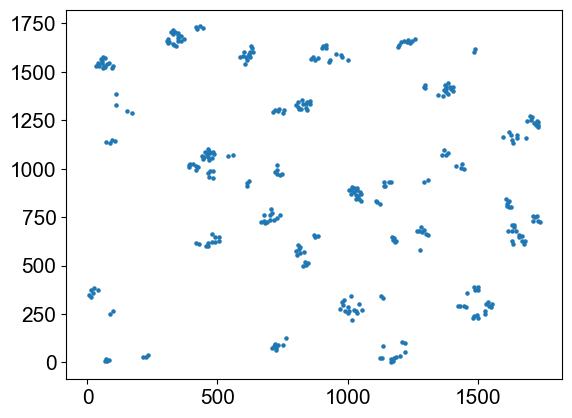

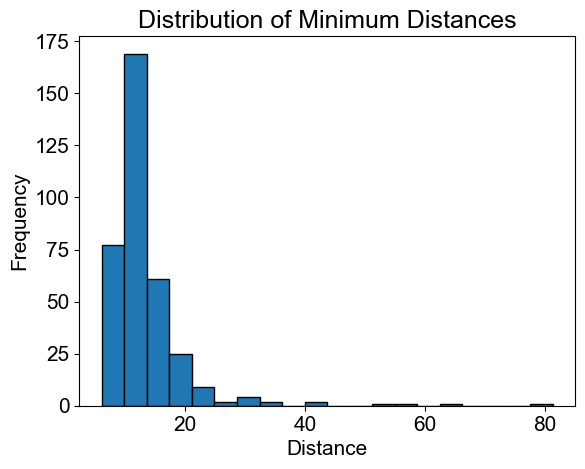

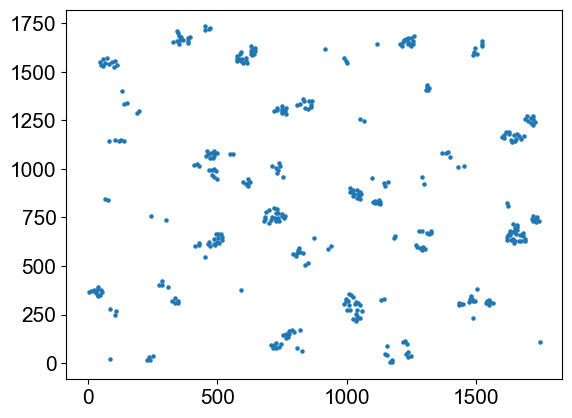

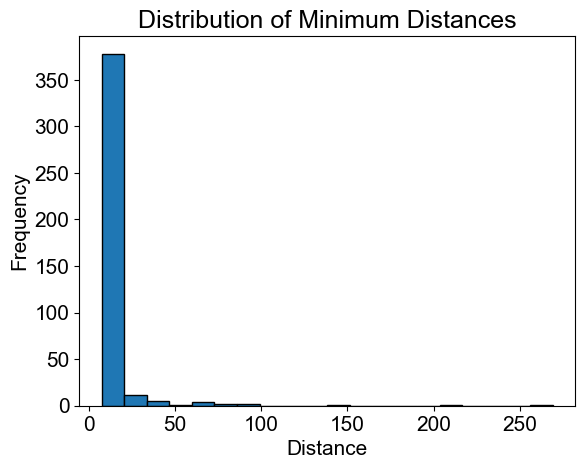

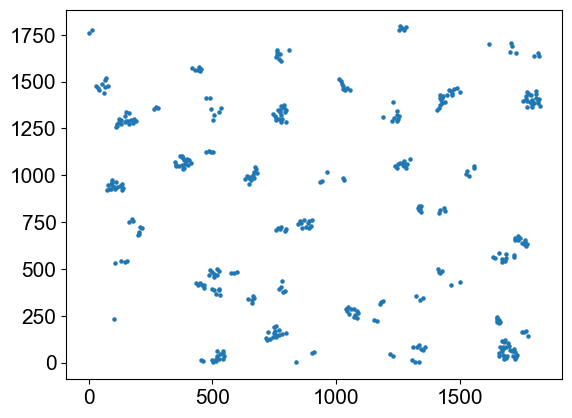

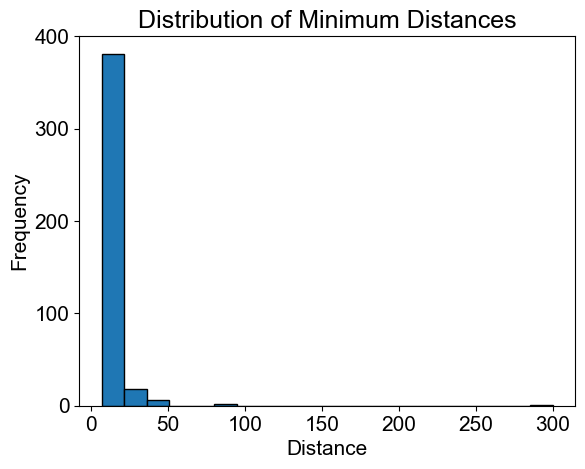

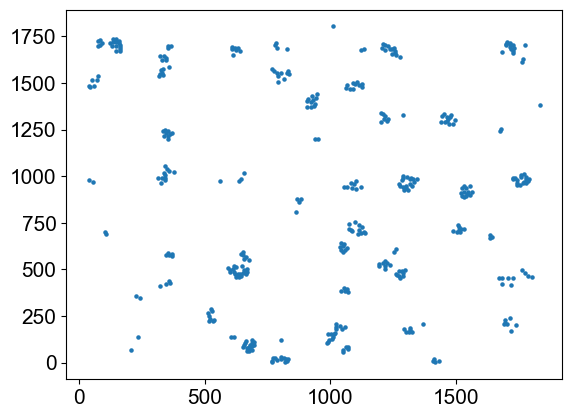

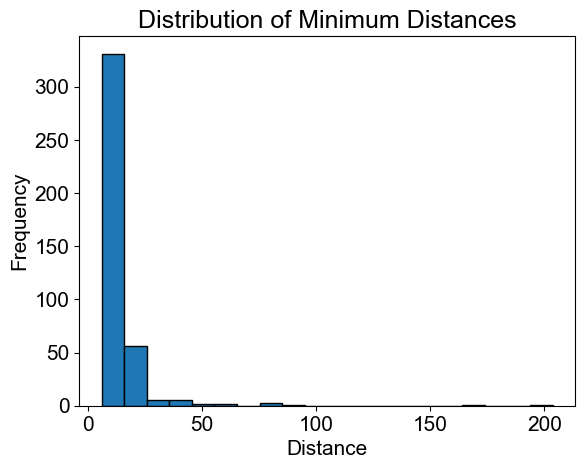

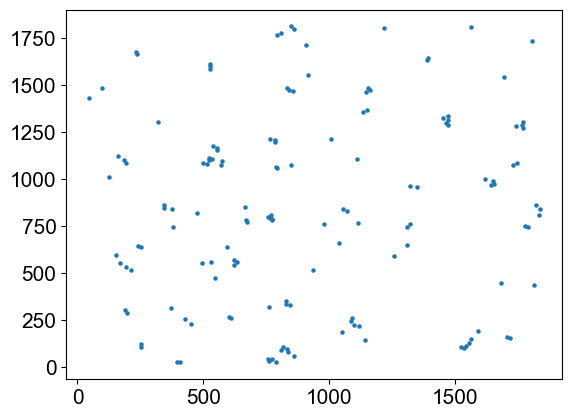

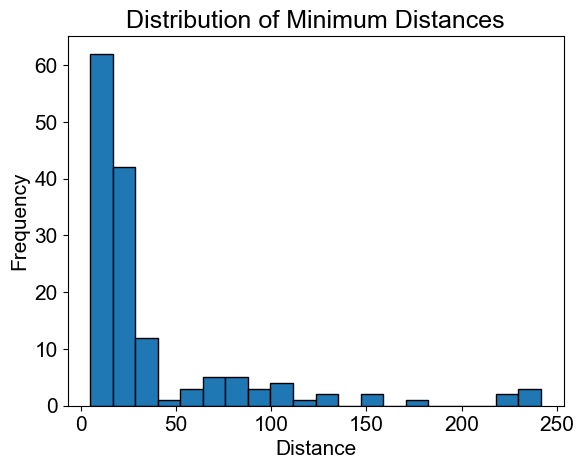

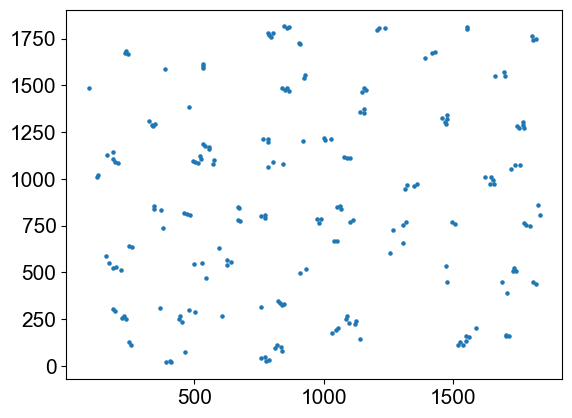

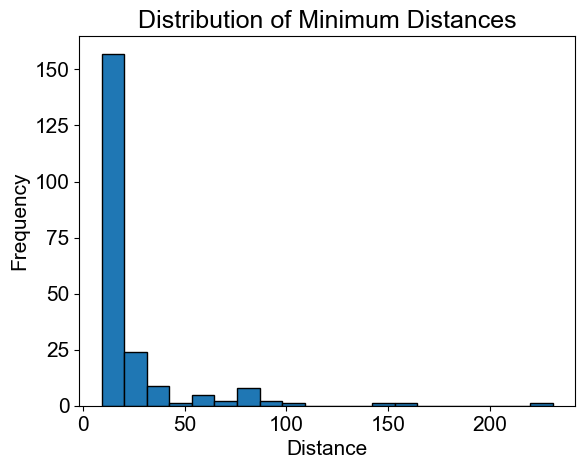

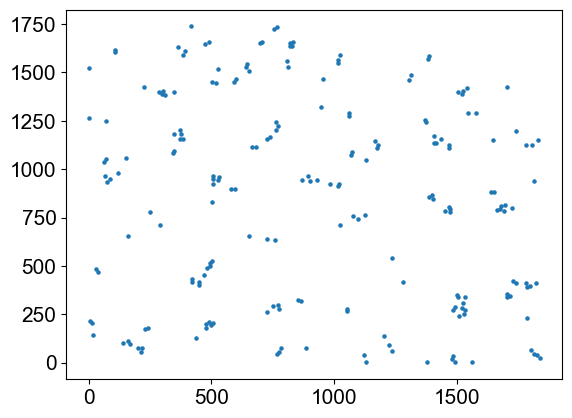

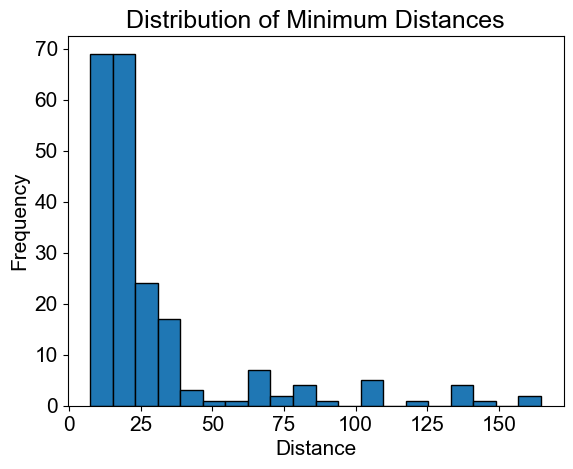

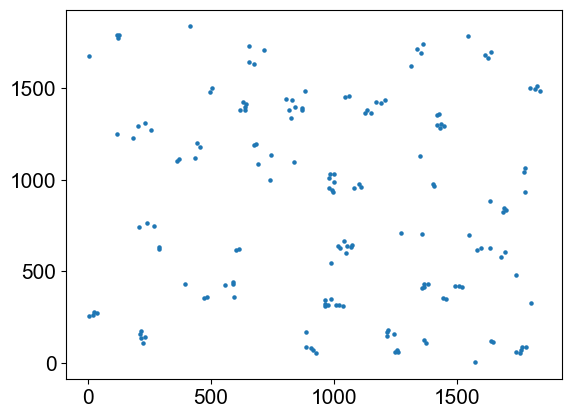

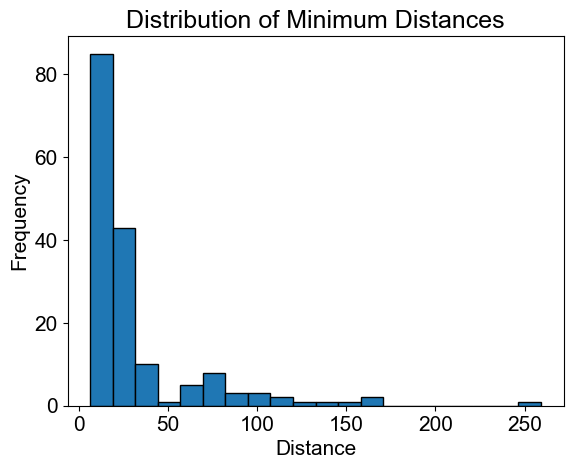

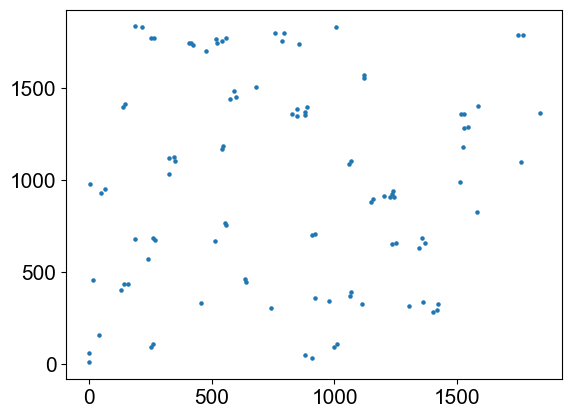

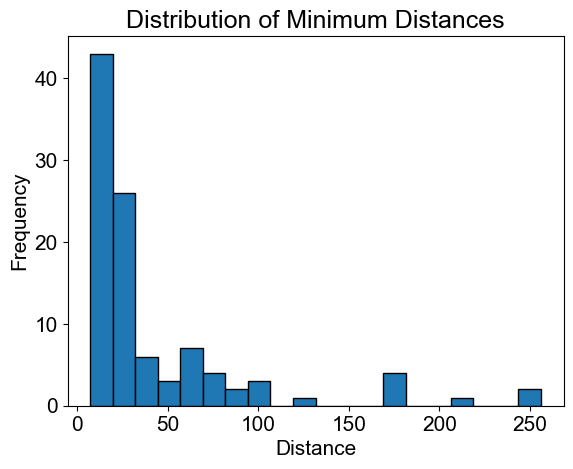

In [271]:
for key in dataset['sample'].unique():
    points = np.array([dataset['centroid_r'][dataset['sample']==key], 
                       dataset['centroid_c'][dataset['sample']==key]], dtype=float)
    plt.scatter(points[0], points[1], s=5)
    plt.show()
    plt.close()
    
    # Need to transpose points matrix for the remaining calculations
    points = points.transpose()
    
    # Calculate pairwise distances using the Euclidean distance metric
    distances = distance.cdist(points, points, 'euclidean')

    # Exclude self-distances (distances to themselves)
    np.fill_diagonal(distances, np.inf)

    # Find the minimum distance for each point
    min_distances = np.min(distances, axis=1)

    # Plot the distribution of minimum distances
    plt.hist(min_distances, bins=20, edgecolor='k')
    plt.title('Distribution of Minimum Distances')
    plt.xlabel('Distance')
    plt.ylabel('Frequency')
    plt.show()
    plt.close()

**From above plot, it looks like 30 is a decent cutoff for maximum distance. Let us now zoom into the distance distribution in the range of 0-30 pixels**

### (Ignore for now) Defining a custom distribution for the distances (this did not work very well, but I have the code anyway)

In [78]:
# Defining a custom distribution of distances given a typical spacing and some random noise:

@jit
def integrand(z, theta, R, a, sigma):
    """Integrand to integrate to get the probability density of distance"""
    term_1 = 1.0/(2*np.pi*sigma**2)*np.exp(-(a**2 + R**2 - 2*a*z*np.cos(theta) - 2*a*np.sqrt(R**2-z**2)*np.sin(theta))/(2*sigma**2))
    term_2 = 1.0/(2*np.pi*sigma**2)*np.exp(-(a**2 + R**2 + 2*a*z*np.cos(theta) - 2*a*np.sqrt(R**2-z**2)*np.sin(theta))/(2*sigma**2))
    term_3 = 1.0/(2*np.pi*sigma**2)*np.exp(-(a**2 + R**2 - 2*a*z*np.cos(theta) + 2*a*np.sqrt(R**2-z**2)*np.sin(theta))/(2*sigma**2))
    term_4 = 1.0/(2*np.pi*sigma**2)*np.exp(-(a**2 + R**2 + 2*a*z*np.cos(theta) + 2*a*np.sqrt(R**2-z**2)*np.sin(theta))/(2*sigma**2))
    return term_1 + term_2 + term_3 + term_4

def evaluate_integral(params, R):
    """Function that evaluates the probability density function at R"""
    integral_inner = lambda theta: quad(integrand, 0.0, R, args=(theta, R, params[0], params[1]))[0]
    integral = quad(integral_inner, 0.0, 2*np.pi)[0]
    return integral

def cdf_custom(R, rmin, rmax, params, dr):
    """Calculate the cumulative distribution function from the lsw distribution for a particular value of r"""
    cdf = np.zeros(len(R))
    r_range = np.arange(rmin, rmax, dr)
    pdf = np.array([evaluate_integral(params, r) for r in r_range])
    for i in range(len(R)):
        cdf[i] = np.sum(pdf[r_range < R[i]])/np.sum(pdf)
    return cdf

def distribution_error(params, cutoff, data, rmax, dr):
    """Objective function to minimize to fit the lsw distribution to data"""
    cdf_inner = lambda x: cdf_custom(R=x, rmin=cutoff, rmax=rmax, params=params, dr=dr)
    ks = ks_1samp(data, cdf_inner)
    return ks.statistic

def fit_distribution(cutoff, data, rmax, params_guess, dr=0.01):
    """Fit the LSW distribution to data using Kolmogorov-Smirnov distance as an optimizing metric"""
    optimum = minimize(distribution_error, params_guess, args=(cutoff, data, rmax, dr), bounds=[(cutoff, rmax), (0.0, rmax)], method='Nelder-Mead')
    return optimum

### Defining a function to fit and display distance distributions

In [55]:
def fit_distance_distributions(dataset, condition):
    """Function to fit the distribution of distances to the nearest neighbor to two different distributions - 
    normal and log normal
    
    NOTE: The radii of the droplets should be in pixels and not in microns.
    """
    
    min_distances = np.array([], dtype=float)
    
    for key in dataset['sample'].unique():
        
        points = np.array([dataset['centroid_r'][(dataset['sample']==key)*(dataset['sample_type'] == condition)], 
                           dataset['centroid_c'][(dataset['sample']==key)*(dataset['sample_type'] == condition)]],
                           dtype=float)
        
        # plt.scatter(points[0]*micron_per_pixel, points[1]*micron_per_pixel, s=5)
        # plt.xlabel(r'X ($\mu$ m)')
        # plt.ylabel(r'Y ($\mu$ m)')
        # plt.title(key)
        # plt.show()
        # plt.close()
        
        if points.size != 0:
            # Need to transpose points matrix for the remaining calculations
            points = points.transpose()

            # Calculate pairwise distances using the Euclidean distance metric
            distances = distance.cdist(points, points, 'euclidean')

            # Exclude self-distances (distances to themselves)
            np.fill_diagonal(distances, np.inf)

            # Find the minimum distance for each point
            min_distances_pairwise = np.min(distances, axis=1)
            min_distances = np.append(min_distances, min_distances_pairwise)
    
    # min_distances = min_distances[min_distances < 30.0]
    
    # calculate the statistics of the distance distribution
    mean = np.mean(min_distances)
    sigma = np.std(min_distances)
    exp_log_mean = np.exp(np.mean(np.log(min_distances)))
    exp_log_sigma = np.exp(np.std(np.log(min_distances)))
    rmin = np.min(min_distances)
    rmax = np.max(min_distances)
    
    # Plot the distribution of minimum distances
    # plt.hist(min_distances*micron_per_pixel, bins=25, edgecolor='k')
    # plt.title('Distribution of Minimum Distances')
    # plt.xlabel(r'Distance ($\mu$ m)')
    # plt.ylabel('Frequency')
    # plt.title(condition)
    # plt.show()
    # plt.close()
    
    # Fit the distribution of minimum distances
    best_normal = fit_normal(cutoff=rmin, data=min_distances, rmax=rmax, params_guess=[mean, sigma])
    r_normal, c_normal = normal(rmin, rmax, best_normal.x[0], best_normal.x[1])
    
    best_log_normal = fit_log_normal(cutoff=rmin, data=min_distances, rmax=rmax, 
                                     params_guess=[exp_log_mean, exp_log_sigma])
    r_log_normal, c_log_normal = lognormal(rmin, rmax, np.log(best_log_normal.x[0]), np.log(best_log_normal.x[1]))
    # best_custom_distribution = fit_distribution(cutoff=rmin, data=min_distances, rmax=rmax, 
    #                                              params_guess=[mean, sigma], dr=0.1)
    # r_custom = np.arange(rmin, rmax, 0.01)
    # c_custom = cdf_custom(r_custom, rmin, rmax, [best_custom_distribution.x[0], best_custom_distribution.x[1]], dr=0.01)
    
    # Get p values of the fits
    best_normal_cdf = lambda x: normal_cdf(r=x, rmin=rmin, rmax=rmax, 
                                           mean=best_normal.x[0], sigma=best_normal.x[1], dr=0.01)
    best_normal_pvalue = kstest(min_distances, best_normal_cdf)
    
    best_log_normal_cdf = lambda x: log_normal_cdf(r=x, rmin=rmin, rmax=rmax, 
                                                   exp_log_mean=best_log_normal.x[0], 
                                                   exp_log_sigma=best_log_normal.x[1], dr=0.01)
    best_log_normal_pvalue = kstest(min_distances, best_log_normal_cdf)
    
    
    print('pvalue Normal:', best_normal_pvalue, 'pvalue Log Normal:', best_log_normal_pvalue)
    
    fitting_stats = [condition, 
                     best_normal.fun, best_normal_pvalue.pvalue, best_normal.x[0]*micron_per_pixel,
                     best_normal.x[1]*micron_per_pixel,
                     best_log_normal.fun, best_log_normal_pvalue.pvalue, best_log_normal.x[0]*micron_per_pixel,
                     best_log_normal.x[1]*micron_per_pixel]
                                             
    plt.hist(min_distances*micron_per_pixel, color='steelblue', alpha=0.6, bins=200, density=True, cumulative=True)
    plt.plot(r_normal*micron_per_pixel, c_normal, label='Normal', color='k', linestyle='-')
    plt.plot(r_log_normal*micron_per_pixel, c_log_normal, label='Log Normal', color='k', linestyle='--')
    # plt.plot(r_custom*micron_per_pixel, c_custom, label='Spacing + Noise', c='r')
    
    plt.xlabel(r'Distance ($\mu$m)')
    plt.ylabel(r'Cumulative distribution function')
    plt.title(condition)
    
    plt.savefig('Figures_for_paper/' + condition + '_fitting_distance_distribution.svg', format='svg', dpi=600)
    plt.savefig('Figures_for_paper/' + condition + '_fitting_distance_distribution.pdf', format='pdf', dpi=600)
    
    plt.legend()
    plt.show()
    plt.close()
    
    return min_distances*micron_per_pixel, fitting_stats

### Fitting droplet spacing distributions

pvalue Normal: KstestResult(statistic=0.06102674097976446, pvalue=2.2896485891675774e-05) pvalue Log Normal: KstestResult(statistic=0.040765380417213004, pvalue=0.01239556846409532)


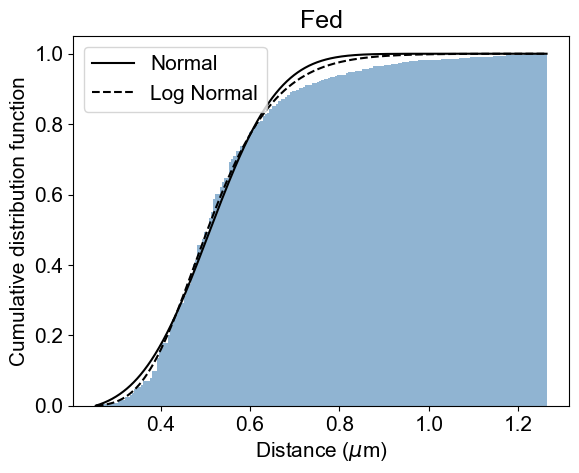

pvalue Normal: KstestResult(statistic=0.054504407019955736, pvalue=0.04222309507054112) pvalue Log Normal: KstestResult(statistic=0.034289467062501355, pvalue=0.42671503161970725)


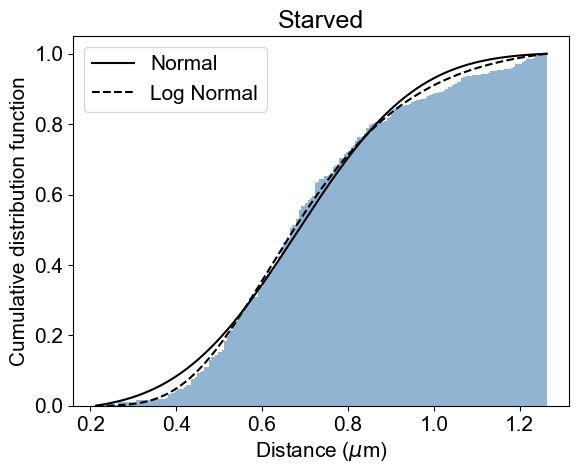

In [565]:
fitting_stats = pd.DataFrame(columns=['Condition', 'KS_Best_Normal', 'pvalue_Best_Normal', 'Mean_Best_Normal (microns)', 
                                      'Std_Best_Normal', 'KS_Best_Log_Normal', 'pvalue_Best_Log_Normal',
                                      'Log_Mean_Best_Log_Normal (microns)', 'Log_Std_Best_Log_Normal (microns)'])
distances = {}

for condition in dataset['sample_type'].unique():
    
    distance_list, fitting_stats_list = fit_distance_distributions(dataset, condition)  
    fitting_stats.loc[len(fitting_stats)] = fitting_stats_list
    distances[condition] = distance_list
    
fitting_stats.to_csv('Fitting_statistics_spacing_distbn_fed_starved.csv')

/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Ttest_indResult(statistic=18.618042992364057, pvalue=5.748875967537601e-66)
0.7043863044923556
0.5330510653648661
0.21174549699090406
0.1502419604480832


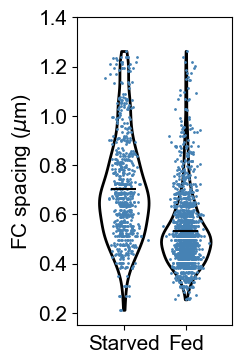

In [566]:
# Violin plots of the spacing distribution

fig, axs = plt.subplots(1, 1, figsize=(2,4))

# Segment the dataset by condition
data = np.array([distances[key] for key in ['Starved', 'Fed']])

# Set the x labels for the plot
def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
labels = ['Starved', 'Fed']
set_axis_style(axs, labels)

# Plot violinplot
parts = axs.violinplot(data, vert=True, widths=0.8, showmeans=True, showextrema=False)

parts['cmeans'].set_color(['k']*len(data))
for pc in parts['bodies']:
    pc.set_facecolor('white')
    pc.set_edgecolor('black')
    pc.set_alpha(1.0)
    pc.set_linewidth(2.0)

# Plot the scatter plot of data
y_list = []
i = 0
for condition in ['Starved', 'Fed']:
    # condition = dataset['sample_type'].unique()[i]
    y = distances[condition]
    y_list.append(y)
    # Add some random "jitter" to the x-axis
    x = np.random.normal(i+1, 0.1, size=len(y))
    axs.scatter(x, y, color='steelblue', alpha=1.0, s=1.0)
    i = i+1
    
    
axs.set_ylabel(r'FC spacing ($\mu$m)')
axs.set_ylim([0.15, 1.4])

plt.savefig('Figures_for_paper/Violin_droplet_distance_fed_starved.svg', format='svg', dpi=600)
plt.savefig('Figures_for_paper/Violin_droplet_distance_fed_starved.pdf', format='pdf', dpi=600)

print(ttest_ind(y_list[0], y_list[1], equal_var=False))

print(np.mean(y_list[0]))
print(np.mean(y_list[1]))

print(np.std(y_list[0]))
print(np.std(y_list[1]))

In [28]:
# Check the whether the fit mean and standard deviation change if we take different amounts of data

cutoff_values = np.linspace(5.0, 12.0, 20)
mean_guess = {'Fed': 0.5/micron_per_pixel, 'Starved': 0.7/micron_per_pixel}

mean_dict = {'Fed': [], 'Starved': []}
sigma_dict = {'Fed': [], 'Starved': []}
pvalue_dict = {'Fed': [], 'Starved': []}

for i in range(len(cutoff_values)):
    print(i)
    for condition in distances.keys():
        data = distances[condition][distances[condition]/micron_per_pixel > cutoff_values[i]]/micron_per_pixel
        rmax = np.max(data)
        exp_log_mean = np.exp(np.mean(np.log(data)))
        exp_log_sigma = np.exp(np.std(np.log(data)))
        # mean = mean_guess[condition]
        # sigma = np.std(data)
        best_log_normal = fit_log_normal(cutoff=cutoff_values[i], 
                                         data=data, rmax=rmax, params_guess=[exp_log_mean, exp_log_sigma])
        r_log_normal, c_log_normal = lognormal(cutoff_values[i], 
                                               rmax, np.log(best_log_normal.x[0]), np.log(best_log_normal.x[1]))
        best_log_normal_cdf = lambda x: log_normal_cdf(r=x, rmin=cutoff_values[i], 
                                                       rmax=rmax, exp_log_mean=best_log_normal.x[0],
                                                       exp_log_sigma=best_log_normal.x[1], dr=0.01)
        best_log_normal_pvalue = kstest(data, best_log_normal_cdf)
        pvalue_dict[condition].append(best_log_normal_pvalue)
        mean_dict[condition].append(best_log_normal.x[0])
        sigma_dict[condition].append(best_log_normal.x[1])
        print(condition, ': ', cutoff_values[i], ',  pvalue: ', best_log_normal_pvalue)
        
        
cutoff_values_microns = np.array(cutoff_values)*micron_per_pixel
mean_dict['Fed'] = np.array(mean_dict['Fed'])*micron_per_pixel
mean_dict['Starved'] = np.array(mean_dict['Starved'])*micron_per_pixel
sigma_dict['Fed'] = np.array(sigma_dict['Fed'])*micron_per_pixel
sigma_dict['Starved'] = np.array(sigma_dict['Starved'])*micron_per_pixel

0
Fed :  5.0 ,  pvalue:  KstestResult(statistic=0.04101313374642168, pvalue=0.011652294475732664)
Starved :  5.0 ,  pvalue:  KstestResult(statistic=0.03463504508097154, pvalue=0.416050461731609)
1
Fed :  5.368421052631579 ,  pvalue:  KstestResult(statistic=0.04098165574081358, pvalue=0.011744444889506662)
Starved :  5.368421052631579 ,  pvalue:  KstestResult(statistic=0.034618423017608646, pvalue=0.4166522957128659)
2
Fed :  5.7368421052631575 ,  pvalue:  KstestResult(statistic=0.04088571065530955, pvalue=0.012029391537521708)
Starved :  5.7368421052631575 ,  pvalue:  KstestResult(statistic=0.03436809029920318, pvalue=0.4257767686047492)
3
Fed :  6.105263157894736 ,  pvalue:  KstestResult(statistic=0.04114743461375994, pvalue=0.011497757251123219)
Starved :  6.105263157894736 ,  pvalue:  KstestResult(statistic=0.034435754652060946, pvalue=0.4232992724002007)
4
Fed :  6.473684210526316 ,  pvalue:  KstestResult(statistic=0.041294959894509695, pvalue=0.01115628305489428)
Starved :  6.4736

Fed: Mean =  0.4954203210290925  (um), Std. dev =  0.05429258122183306
Starved: Mean =  0.6764408255417106  (um), Std. dev =  0.05876895221822408


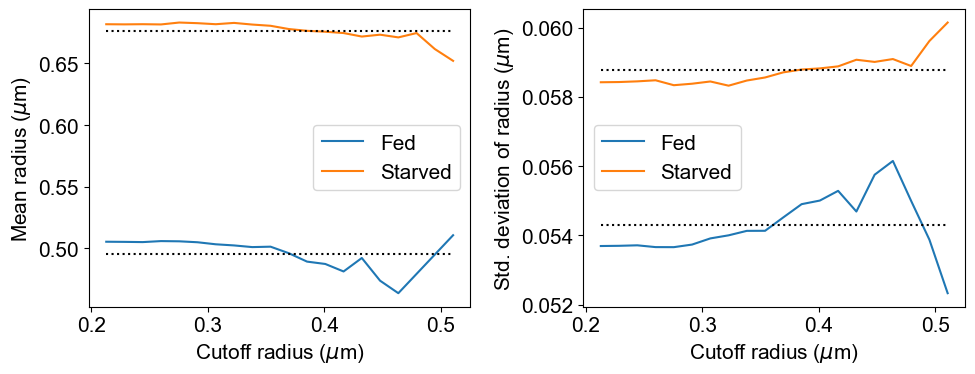

In [29]:
# Plot the above results

print('Fed: Mean = ', str(np.mean(mean_dict['Fed'])), ' (um), Std. dev = ', str(np.mean(sigma_dict['Fed'])))
print('Starved: Mean = ', str(np.mean(mean_dict['Starved'])), ' (um), Std. dev = ', str(np.mean(sigma_dict['Starved'])))

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(cutoff_values_microns, mean_dict['Fed'], label='Fed')
axs[0].plot(cutoff_values_microns, mean_dict['Starved'], label='Starved')
axs[0].plot(cutoff_values_microns, np.mean(mean_dict['Starved'])*np.ones(len(cutoff_values_microns)), 
            linestyle=':', c='k')
axs[0].plot(cutoff_values_microns, np.mean(mean_dict['Fed'])*np.ones(len(cutoff_values_microns)), 
            linestyle=':', c='k')
axs[0].set_ylabel('Mean radius ($\mu$m)')
axs[0].set_xlabel('Cutoff radius ($\mu$m)')
axs[0].legend()

axs[1].plot(cutoff_values_microns, sigma_dict['Fed'], label='Fed')
axs[1].plot(cutoff_values_microns, sigma_dict['Starved'], label='Starved')
axs[1].plot(cutoff_values_microns, np.mean(sigma_dict['Starved'])*np.ones(len(cutoff_values_microns)), 
            linestyle=':', c='k')
axs[1].plot(cutoff_values_microns, np.mean(sigma_dict['Fed'])*np.ones(len(cutoff_values_microns)), linestyle=':',
           c='k')
axs[1].set_ylabel('Std. deviation of radius ($\mu$m)')
axs[1].set_xlabel('Cutoff radius ($\mu$m)')
axs[1].legend()
fig.tight_layout()

plt.savefig('Figures_for_paper/Vary_cutoff_distance_fed_starved.svg', format='svg', dpi=600)
plt.savefig('Figures_for_paper/Vary_cutoff_distance_fed_starved.pdf', format='pdf', dpi=600)
plt.show()
plt.close()
# fitting_stats.to_csv('Fitting_statistics_size_distbn_fed_starved.csv')

# Accounting for droplet size distribution normalizing for cell-cell variability

### The point here is to make a statement on the shape of the distribution, whether it is Gaussian or LSW. However, we can not say anything about how size changes upon perturbation. For this, refer to the analysis above

### Visualizing clustering performance using DBSCAN

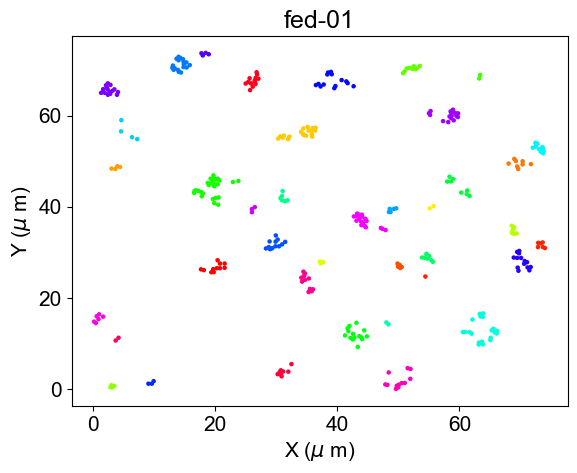

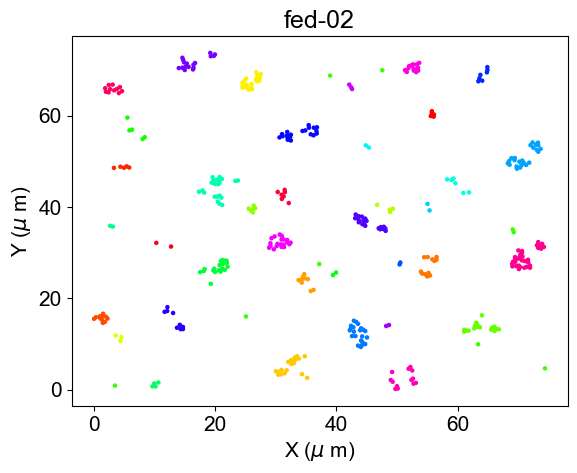

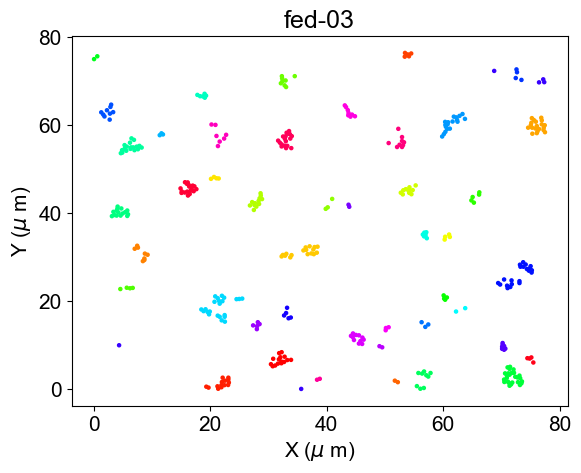

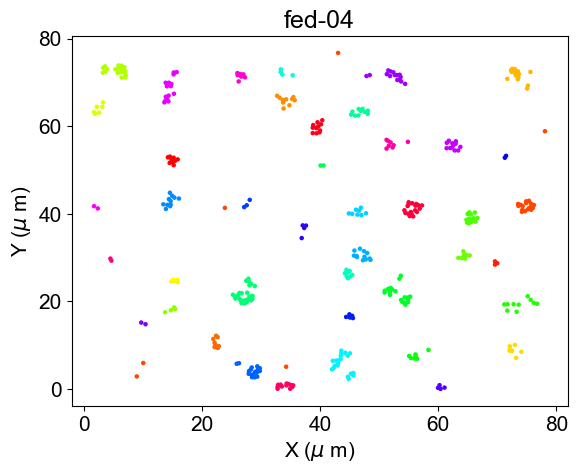

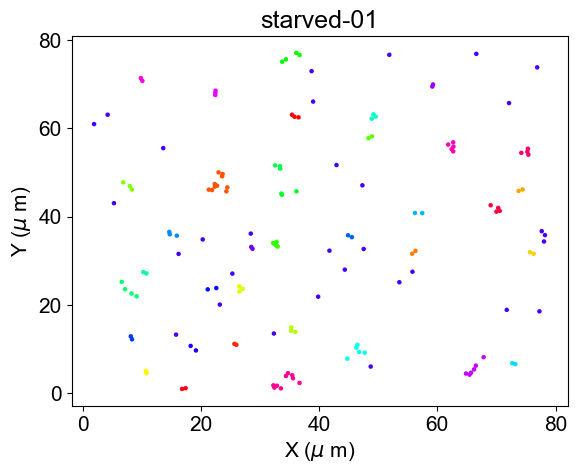

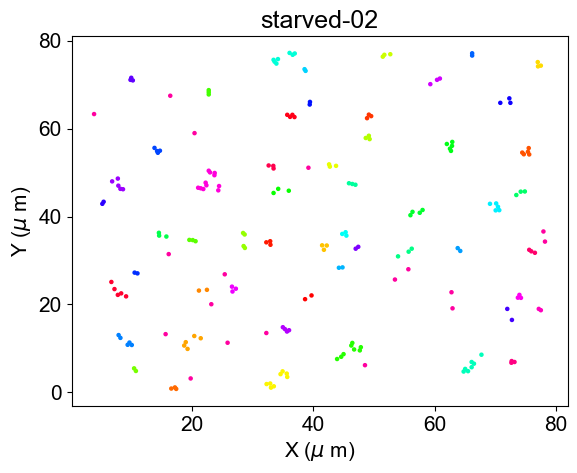

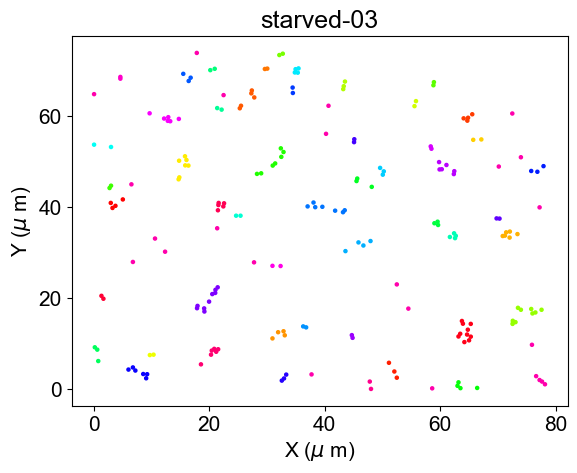

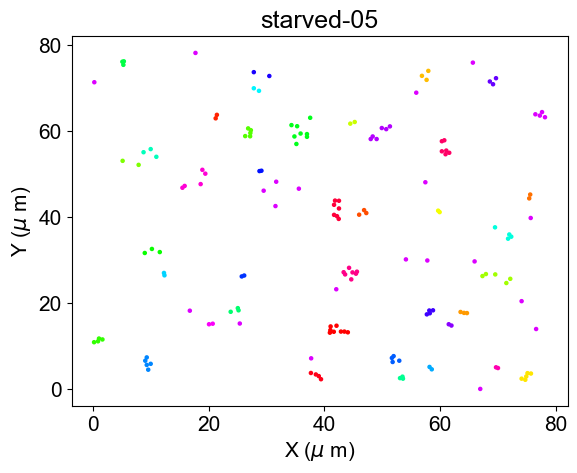

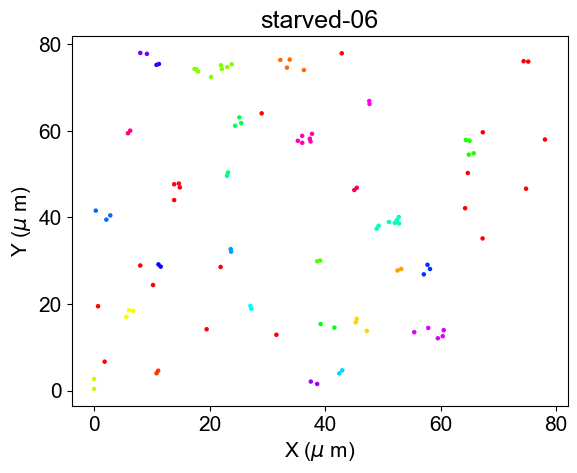

In [207]:
key_list = [['fed-01', 'fed-02', 'fed-03', 'fed-04'], 
            ['starved-01', 'starved-02', 'starved-03', 'starved-05', 'starved-06']]

for keys in key_list:
    for key in keys:

        points = np.array([dataset['centroid_r'][dataset['sample']==key], 
                           dataset['centroid_c'][dataset['sample']==key]], dtype=float)
        # Convert x and y coordinate of points from pixels to microns
        points = points*micron_per_pixel

        # Apply DBSCAN:
        # Distance within which points are considered neighbors. 
        epsilon = 3.0 # microns  
        # We use this value as most points have their nearest neighbors within this distance from the 
        # distribution of spacings
        min_samples = 2  # Minimum number of points to form a dense region
        dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
        clusters = dbscan.fit_predict(points.transpose())

        # Coloring clusters randomly
        color_array = np.arange(np.max(clusters)+1)
        np.random.shuffle(color_array)
        color_assignments = [color_array[clust_num] for clust_num in clusters]

        # Visualize the clusters
        plt.scatter(points[0], points[1], s=5,c=color_assignments, cmap='hsv')
        plt.xlabel(r'X ($\mu$ m)')
        plt.ylabel(r'Y ($\mu$ m)')
        plt.title(key)
        plt.show()
        plt.close()

**Note:** Use a value of 3 microns as the distance cutoff, as this seems to cluster points reasonably well

In [42]:
def cluster_and_get_z_scores(points, radii):
    """Function to cluster points based on their x and y coordinates and get the z scores of the 
    raddi of points that are within a cluster"""
        
    # Arrays to score z scores and lsw normalized values
    z_values = np.array([], dtype=float)
    log_z_values = np.array([], dtype=float)
    lsw_norm_values = np.array([], dtype=float)
    cluster_sizes = np.array([], dtype=int)

    # Apply DBSCAN:
    
    # Distance within which points are considered neighbors. 
    epsilon = 2.0 # microns  
    # We use this value as most points have their nearest neighbors within this distance from 
    # the distribution of spacings
    min_samples = 3  # Minimum number of points to form a dense region
    dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
    clusters = dbscan.fit_predict(points.transpose())
    
    # Find the cluster numbers that have at least min_num_per_cluster points
    min_num_per_cluster = 2
    # We checked and ensured that at least half the clusters had at least 4 points
    counts_of_points_in_clusters = Counter(clusters)
    cluster_numbers_with_at_least_n_points = list()
    for clust_num, counts in counts_of_points_in_clusters.items():
        if counts >= min_num_per_cluster and clust_num >=0:
            cluster_numbers_with_at_least_n_points.append(clust_num)
    
    # Fitting normal distribution
    for cluster_num in cluster_numbers_with_at_least_n_points:
        radii_in_cluster = radii[clusters == cluster_num]    
        z_values = np.append(z_values, zscore(radii_in_cluster))
        lsw_norm_values = np.append(lsw_norm_values, radii_in_cluster/np.mean(radii_in_cluster))
        log_z_values = np.append(log_z_values, zscore(np.log(radii_in_cluster)))
        cluster_sizes = np.append(cluster_sizes, len(radii_in_cluster))
        
    return z_values, log_z_values, lsw_norm_values, cluster_sizes

In [43]:
def fit_z_scores(z_values, log_z_values, lsw_norm_values, figname):

    # Fit the data to a Gaussian distribution
    mean, std_dev = norm.fit(z_values)

    # Kolmogorov-Smirnov test to check goodness of fit for normal distribution
    ks_statistic, ks_p_value = kstest(z_values, 'norm', args=(mean, std_dev))

    # Plot the histogram of the data along with the fitted Gaussian distribution
    plt.hist(z_values, bins=40, density=True, cumulative=True, alpha=0.6, color='g', label='Data')
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.cdf(x, mean, std_dev)
    plt.plot(x, p, 'k', linewidth=2, label='Fitted Gaussian')

    plt.title('Normal Distribution')
    # plt.xlabel(r'$z_{normal} = (x-\mu)/\sigma$')
    plt.xlabel(r'$z_{normal}$')
    plt.ylabel('Cumulative distribution function')
    
    plt.savefig('Figures_for_paper/' + figname + '_fitting_distribution_with_cell_cell_variability_normal.svg', 
                format='svg', dpi=600)
    plt.savefig('Figures_for_paper/' + figname + '_fitting_distribution_with_cell_cell_variability_normal.pdf', 
                format='pdf', dpi=600)
    plt.legend()
    plt.show()

    # Display KS test results 
    print(f"KS Statistic: {ks_statistic}")
    print(f"P-value: {ks_p_value}")
    
    # Fit the data to a log normal distribution and get the KS score
    # Note: the log_z_acores should follow a normal distribution. Therefore, we just fit a normal distribution
    
    mean, std_dev = norm.fit(log_z_values)

    # Kolmogorov-Smirnov test to check goodness of fit for normal distribution
    ks_statistic, ks_p_value = kstest(log_z_values, 'norm', args=(mean, std_dev))

    # Plot the histogram of the data along with the fitted Gaussian distribution
    plt.hist(log_z_values, bins=40, density=True, cumulative=True, alpha=0.6, color='g', label='Data')
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.cdf(x, mean, std_dev)
    plt.plot(x, p, 'k', linewidth=2, label='Fitted Log Normal')

    plt.title('Log Normal Distribution')
    # plt.xlabel(r'$z_{log~normal} = (log(x)-log(\mu))/\sigma$')
    plt.xlabel(r'$z_{log~normal}$')
    plt.ylabel('Cumulative distribution function')
    
    plt.savefig('Figures_for_paper/' + figname + '_fitting_distribution_with_cell_cell_variability_log_normal.svg', 
                format='svg', dpi=600)
    plt.savefig('Figures_for_paper/' + figname + '_fitting_distribution_with_cell_cell_variability_log_normal.pdf', 
                format='pdf', dpi=600)
    plt.legend()
    plt.show()

    # Display KS test results 
    print(f"KS Statistic: {ks_statistic}")
    print(f"P-value: {ks_p_value}")
    

    # Fit the data to a LSW distribution and get the KS score
    lsw_norm_cdf = lambda x: lsw_cdf(r=x, rmin=np.min(lsw_norm_values), rmax=np.max(lsw_norm_values), mean=1.0, dr=0.01)
    ks_statistic, ks_p_value = kstest(lsw_norm_values, lsw_norm_cdf)

    # Plot the histogram of the data along with the fitted Gaussian distribution
    plt.hist(lsw_norm_values, bins=40, density=True, cumulative=True, alpha=0.6, color='g', label='Data')
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = lsw_norm_cdf(x)
    plt.plot(x, p, 'k', linewidth=2, label='Fitted LSW')

    # plt.title('LSW fit (mean = %.2f)' % (1.0))
    plt.title('LSW Distribution')
    # plt.xlabel(r'$z_{LSW} = x/\mu$')
    plt.xlabel(r'$z_{LSW}$')
    plt.ylabel('Cumulative distribution function')
    
    plt.savefig('Figures_for_paper/' + figname + '_fitting_distribution_with_cell_cell_variability_LSW.svg', 
                format='svg', dpi=600)
    plt.savefig('Figures_for_paper/' + figname + '_fitting_distribution_with_cell_cell_variability_LSW.pdf', 
                format='pdf', dpi=600)
    
    plt.legend()
    plt.show()

    # Display KS test results 
    print(f"KS Statistic: {ks_statistic}")
    print(f"P-value: {ks_p_value}")

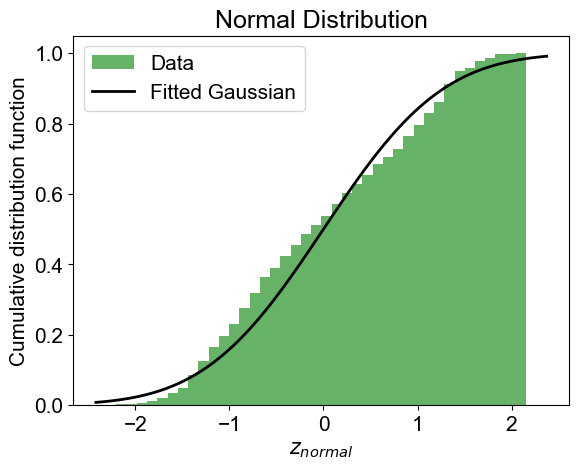

KS Statistic: 0.07863844750967414
P-value: 0.0035676848157216523


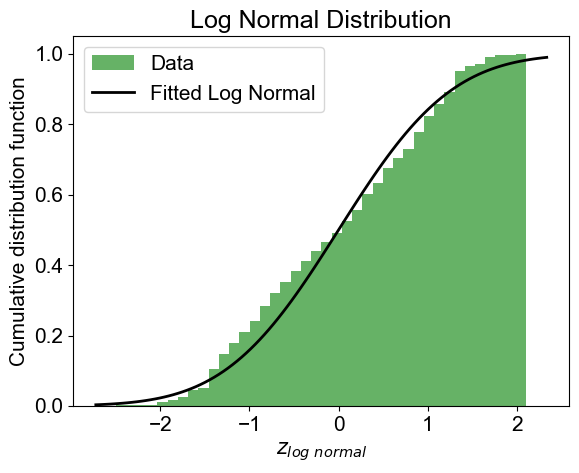

KS Statistic: 0.07063083630875489
P-value: 0.012082947184159325


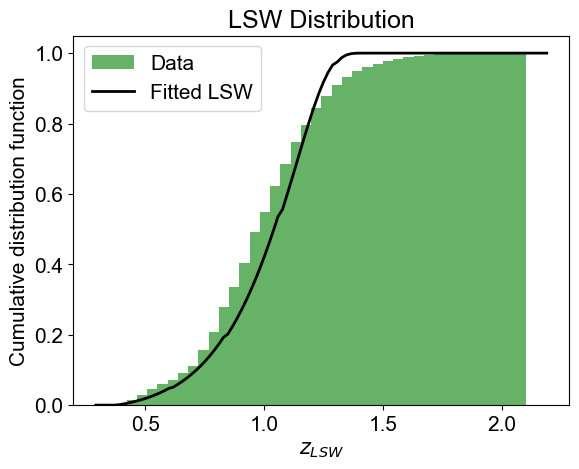

KS Statistic: 0.11088298232787064
P-value: 6.948407840116818e-06


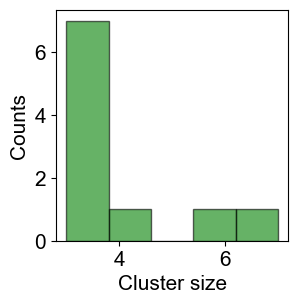

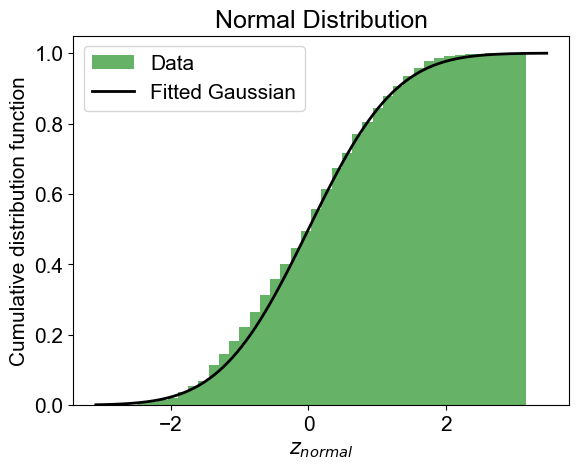

KS Statistic: 0.030526507767607014
P-value: 0.12582132873003726


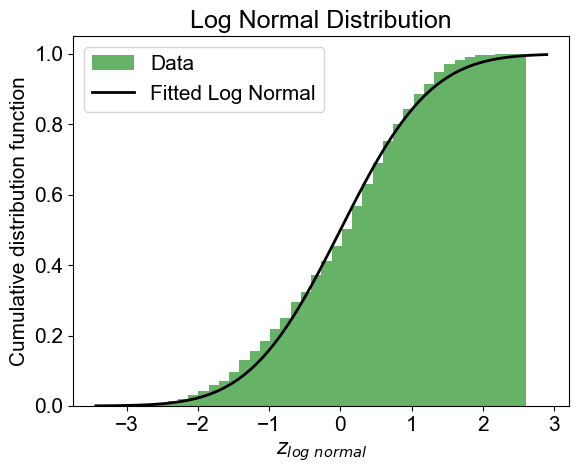

KS Statistic: 0.06216983199208814
P-value: 2.1596589881919933e-05


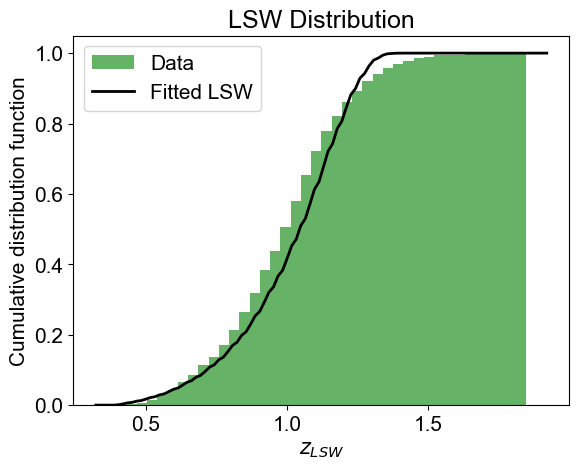

KS Statistic: 0.0900040750232659
P-value: 7.82355698282798e-11


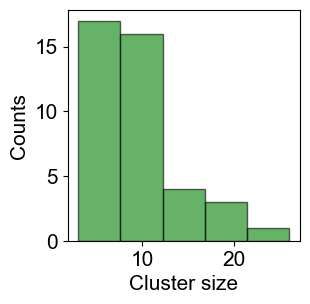

In [567]:
cluster_sizes_list = []

### Clustering points and plotting normalized size distribution for starved cells

keys = ['starved-01', 'starved-02', 'starved-03', 'starved-05', 'starved-06']

z_values = np.array([], dtype=float)
log_z_values = np.array([], dtype=float)
lsw_norm_values = np.array([], dtype=float)

for key in keys:
    
    points_pixels = np.array([dataset['centroid_r'][dataset['sample']==key], 
                              dataset['centroid_c'][dataset['sample']==key]], dtype=float)
    # Convert x and y coordinate of points from pixels to microns
    points = points_pixels*micron_per_pixel
    # Get the radii of the droplets present at these positions
    radii = np.array(dataset['radius'][dataset['sample']==key], dtype=float)
    z_scores, log_z_scores, lsw_scores, cluster_sizes = cluster_and_get_z_scores(points, radii)
    z_values = np.append(z_values, z_scores)
    lsw_norm_values = np.append(lsw_norm_values, lsw_scores)
    log_z_values = np.append(log_z_values, log_z_scores)
    
fit_z_scores(z_values, log_z_values, lsw_norm_values, figname='Starved')

cluster_sizes_list.append(cluster_sizes)

fig,axs = plt.subplots(1,1,figsize=(3,3))
axs.hist(cluster_sizes, bins=5, edgecolor='k', color='g', alpha=0.6)
axs.set_xlabel('Cluster size')
axs.set_ylabel('Counts')
plt.show()
plt.close()

### Clustering points and plotting normalized size distribution for fed cells

keys = ['fed-01', 'fed-02', 'fed-03', 'fed-04']

z_values = np.array([], dtype=float)
log_z_values = np.array([], dtype=float)
lsw_norm_values = np.array([], dtype=float)

for key in keys:
    
    points_pixels = np.array([dataset['centroid_r'][dataset['sample']==key], 
                              dataset['centroid_c'][dataset['sample']==key]], dtype=float)
    # Convert x and y coordinate of points from pixels to microns
    points = points_pixels*micron_per_pixel
    # Get the radii of the droplets present at these positions
    radii = np.array(dataset['radius'][dataset['sample']==key], dtype=float)
    z_scores, log_z_scores, lsw_scores, cluster_sizes = cluster_and_get_z_scores(points, radii)
    z_values = np.append(z_values, z_scores)
    lsw_norm_values = np.append(lsw_norm_values, lsw_scores)
    log_z_values = np.append(log_z_values, log_z_scores)
    
fit_z_scores(z_values, log_z_values, lsw_norm_values, figname='Fed')

cluster_sizes_list.append(cluster_sizes)

fig,axs = plt.subplots(1,1,figsize=(3,3))
axs.hist(cluster_sizes, bins=5, color='g', edgecolor='k', alpha=0.6)
axs.set_xlabel('Cluster size')
axs.set_ylabel('Counts')
plt.show()
plt.close()

/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


3.8
9.24390243902439


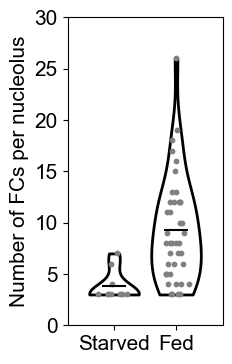

In [568]:
# Violin plots of the spacing distribution

fig, axs = plt.subplots(1, 1, figsize=(2,4))

# Segment the dataset by condition
data = np.array(cluster_sizes_list)

# Plot violinplot
parts = axs.violinplot(data, vert=True, widths=0.8, showmeans=True, showextrema=False)

parts['cmeans'].set_color(['k']*len(data))
for pc in parts['bodies']:
    pc.set_facecolor('white')
    pc.set_edgecolor('black')
    pc.set_alpha(1.0)
    pc.set_linewidth(2.0)

# Plot the scatter plot of data
for i in range(2):
    y = data[i]
    # Add some random "jitter" to the x-axis
    x = np.random.normal(i+1, 0.1, size=len(y))
    axs.scatter(x, y, color='grey', alpha=1.0, s=10.0)
    
# Set the x labels for the plot
def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
labels = ['Starved', 'Fed']
set_axis_style(axs, labels)

axs.set_ylabel(r'Number of FCs per nucleolus')
axs.set_ylim([0, 30])

plt.savefig('Figures_for_paper/Violin_droplet_number_fed_starved.svg', format='svg', dpi=600)
plt.savefig('Figures_for_paper/Violin_droplet_number_fed_starved.pdf', format='pdf', dpi=600)

ttest_ind(data[0], data[1], equal_var=False)

print(np.mean(data[0]))
print(np.mean(data[1]))

# Drug inhibition experiments

In [569]:
dataset = pd.read_csv('Data/transcriptional_inhibition_data.csv')
dataset['radius'] = np.divide(dataset['pixels'], np.pi)**0.5
dataset['radius (microns)'] = dataset['radius']*micron_per_pixel
dataset['sample_type'] = [val[0] for val in dataset['sample'].str.split('-')]
dataset.head()

,sample,spot_id,pixels,mean_intensity,centroid_r,centroid_c,microns,radius,radius (microns),sample_type
0,Control-roi-01,1,21,0.071200,1,969,0.037979,2.585441,0.110019,Control
1,Control-roi-01,2,23,0.052959,1,1055,0.041597,2.705758,0.115139,Control
2,Control-roi-01,3,23,0.044684,3,1019,0.041597,2.705758,0.115139,Control
3,Control-roi-01,4,20,0.038597,5,978,0.036171,2.523133,0.107367,Control
4,Control-roi-01,5,9,0.031769,4,1039,0.016277,1.692569,0.072024,Control


0.25716525559610925

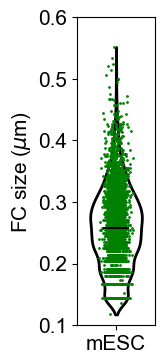

In [576]:
# Plot violin plot of the data

fig, axs = plt.subplots(1, 1, figsize=(1,4))

# Segment the dataset by condition
data = 2.0*np.array(dataset[dataset['sample_type'] == 'Control']['radius (microns)'])

# Plot violinplot
parts = axs.violinplot(data, vert=True, widths=1.0, showmeans=True, showextrema=False)

parts['cmeans'].set_color(['k']*len(data))
for pc in parts['bodies']:
    pc.set_facecolor('white')
    pc.set_edgecolor('black')
    pc.set_alpha(1.0)
    pc.set_linewidth(2.0)
    
# Set the x labels for the plot
def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
labels = ['mESC']
set_axis_style(axs, labels)

# Plot the scatter plot of data
condition = 'Control'
y = dataset[dataset['sample_type'] == condition]['radius (microns)'].dropna()
# Add some random "jitter" to the x-axis
x = np.random.normal(1, 0.1, size=len(y))
axs.scatter(x, 2.0*y, color='green', marker='o', alpha=1.0, s=1.0)

axs.set_ylabel(r'FC size ($\mu$m)')
axs.set_ylim([0.1, 0.6])

plt.savefig('Figures_for_paper/Violin_droplet_size_mESC.svg', format='svg', dpi=600)
plt.savefig('Figures_for_paper/Violin_droplet_size_mESC.pdf', format='pdf', dpi=600)

np.mean(2.0*y)

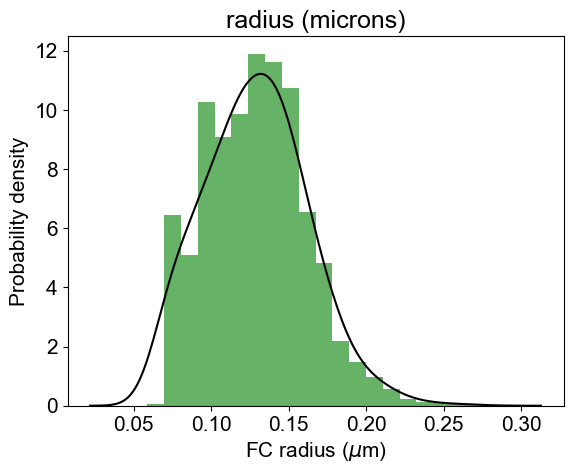

In [62]:
axs = dataset[(dataset.sample_type == 'Control')].hist(column='radius (microns)', bins=20, grid=False,
                                               density=True, cumulative=False, alpha=0.6, color='g', label='Data')

sns.kdeplot(data=dataset[(dataset.sample_type == 'Control')]['radius (microns)'], bw_adjust=2.0, color='k')
plt.ylabel('Probability density')
plt.xlabel('FC radius ($\mu$m)')
plt.savefig('Figures_for_paper/Droplet_size_pdf_control.svg', format='svg', dpi=600)
plt.savefig('Figures_for_paper/Droplet_size_pdf_control.pdf', format='pdf', dpi=600)

/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Ttest_indResult(statistic=-29.525014996943614, pvalue=6.264617684817625e-138)
0.25716525559610925
0.40441926773765124
0.0658278322750605
0.14766398669623185


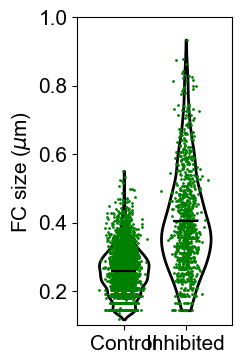

In [577]:
# Plot violin plot of the data

fig, axs = plt.subplots(1, 1, figsize=(2,4))

# Segment the dataset by condition
data = 2.0*np.array([dataset[dataset['sample_type'] == 'Control']['radius (microns)'], 
                     dataset[dataset['sample_type'] == 'Inhib']['radius (microns)']])

# Plot violinplot
parts = axs.violinplot(data, vert=True, widths=0.8, showmeans=True, showextrema=False)

parts['cmeans'].set_color(['k']*len(data))
for pc in parts['bodies']:
    pc.set_facecolor('white')
    pc.set_edgecolor('black')
    pc.set_alpha(1.0)
    pc.set_linewidth(2.0)
    
# Set the x labels for the plot
def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
labels = ['Control', 'Inhibited']
set_axis_style(axs, labels)

# Plot the scatter plot of data
y_list = []
for i in range(len(dataset['sample_type'].unique())):
    condition = dataset['sample_type'].unique()[i]
    y = 2.0*dataset[dataset['sample_type'] == condition]['radius (microns)'].dropna()
    y_list.append(y)
    # Add some random "jitter" to the x-axis
    x = np.random.normal(i+1, 0.1, size=len(y))
    axs.scatter(x, y, color='green', marker='o', alpha=1.0, s=1.0)

axs.set_ylabel(r'FC size ($\mu$m)')
axs.set_ylim([0.1, 1.0])

plt.savefig('Figures_for_paper/Violin_droplet_size_inhibition.svg', format='svg', dpi=600)
plt.savefig('Figures_for_paper/Violin_droplet_size_inhibition.pdf', format='pdf', dpi=600)

print(ttest_ind(y_list[0], y_list[1], equal_var=False))

print(np.mean(y_list[0]))
print(np.mean(y_list[1]))

print(np.std(y_list[0]))
print(np.std(y_list[1]))

/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Control
Best LSW: 0.10627829431027991 Best Normal: 0.034905012721745385 Best Log Normal: 0.049604583476603806
Mean size: 2.9733782143875986
pvalue LSW: KstestResult(statistic=0.10627829431027991, pvalue=1.9990005278793116e-43) pvalue Normal: KstestResult(statistic=0.034905012721745385, pvalue=4.6386476373638276e-05) pvalue Log Normal: KstestResult(statistic=0.049604583476603806, pvalue=8.796684176726098e-10)


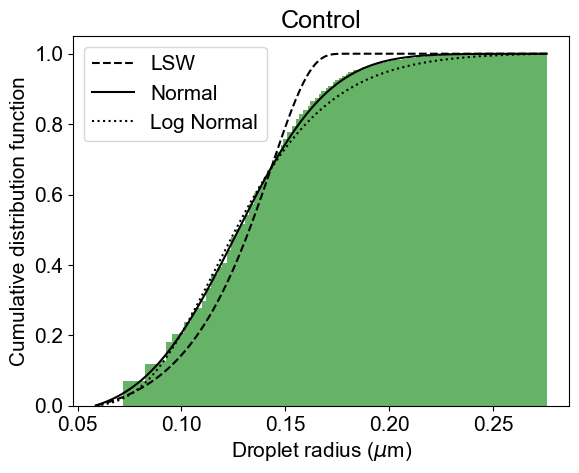

Inhib
Best LSW: 0.1785869760684453 Best Normal: 0.03625421554879049 Best Log Normal: 0.024943687760259257
Mean size: 4.376776068700291
pvalue LSW: KstestResult(statistic=0.1785869760684453, pvalue=5.65871848467441e-26) pvalue Normal: KstestResult(statistic=0.03625421554879049, pvalue=0.17648922650821175) pvalue Log Normal: KstestResult(statistic=0.024943687760259257, pvalue=0.6111257060031602)


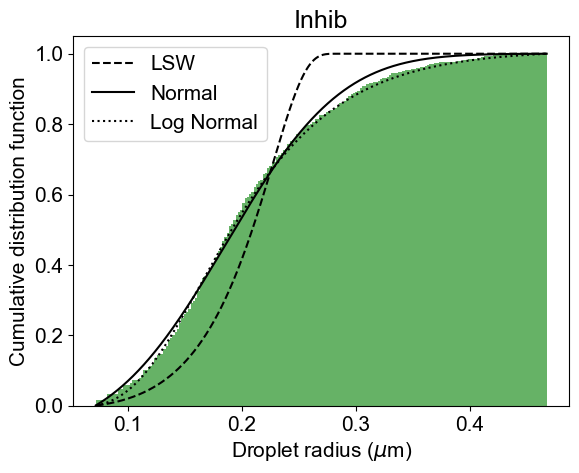

In [56]:
fitting_stats = pd.DataFrame(columns=['Condition',
                                      'KS_Best_LSW', 'pvalue_Best_LSW', 'Mean_Best_LSW (microns)', # LSW
                                      'KS_Best_Normal', 'pvalue_Best_Normal', 'Mean_Best_Normal (microns)',
                                      'Std_Best_Normal (microns)', # Normal
                                      'KS_Best_Log_Normal', 'pvalue_Best_Log_Normal', 'Log_Mean_Best_Log_Normal (microns)',
                                      'Log_Std_Best_Log_Normal (microns)'] # Log normal
                            )

for condition in dataset['sample_type'].unique():
    
    data = dataset[(dataset['sample_type']==condition)]['radius']
    fitting_stats_list = fit_distributions_and_return_stats(data, condition, flag=1)
    fitting_stats.loc[len(fitting_stats)] = fitting_stats_list
    
# fitting_stats.to_csv('Fitting_statistics_size_distbn_fed_starved.csv')

In [57]:
# Check the whether the fit mean and standard deviation change if we take different amounts of data

cutoff_values = np.linspace(1.2, 3.2, 20)
mean_guess = {'Control': 0.15/micron_per_pixel, 'Inhib': 0.19/micron_per_pixel}

mean_dict = {'Control': [], 'Inhib': []}
sigma_dict = {'Control': [], 'Inhib': []}
pvalue_dict = {'Control': [], 'Inhib': []}

for i in range(len(cutoff_values)):
    print(i)
    for condition in dataset['sample_type'].unique():
        data = dataset[(dataset['sample_type'] == condition)*
                       (dataset['radius'] > cutoff_values[i])]['radius']
        rmax = np.max(data)
        mean = mean_guess[condition]
        sigma = np.std(data)
        best_normal = fit_normal(cutoff=cutoff_values[i], data=data, rmax=rmax, params_guess=[mean, sigma])
        r_normal, c_normal = normal(cutoff_values[i], rmax, best_normal.x[0], best_normal.x[1])
        best_normal_cdf = lambda x: normal_cdf(r=x, rmin=cutoff_values[i], rmax=rmax, mean=best_normal.x[0], 
                                           sigma=best_normal.x[1], dr=0.01)
        best_normal_pvalue = kstest(data, best_normal_cdf)
        pvalue_dict[condition].append(best_normal_pvalue)
        mean_dict[condition].append(best_normal.x[0])
        sigma_dict[condition].append(best_normal.x[1])
        print(condition, ': ', cutoff_values[i], ',  pvalue: ', best_normal_pvalue)
        
        
cutoff_values_microns = np.array(cutoff_values)*micron_per_pixel
mean_dict['Control'] = np.array(mean_dict['Control'])*micron_per_pixel
mean_dict['Inhib'] = np.array(mean_dict['Inhib'])*micron_per_pixel
sigma_dict['Control'] = np.array(sigma_dict['Control'])*micron_per_pixel
sigma_dict['Inhib'] = np.array(sigma_dict['Inhib'])*micron_per_pixel

0
Control :  1.2 ,  pvalue:  KstestResult(statistic=0.03842039882589324, pvalue=4.860089251731115e-06)
Inhib :  1.2 ,  pvalue:  KstestResult(statistic=0.04093854668634711, pvalue=0.09087153594339425)
1
Control :  1.305263157894737 ,  pvalue:  KstestResult(statistic=0.03587423740816792, pvalue=2.5447614562462683e-05)
Inhib :  1.305263157894737 ,  pvalue:  KstestResult(statistic=0.040144115930066615, pvalue=0.10228313753347806)
2
Control :  1.4105263157894736 ,  pvalue:  KstestResult(statistic=0.03491314110038491, pvalue=4.626934865315018e-05)
Inhib :  1.4105263157894736 ,  pvalue:  KstestResult(statistic=0.03915087914483084, pvalue=0.1181993136411964)
3
Control :  1.5157894736842104 ,  pvalue:  KstestResult(statistic=0.04171411281896631, pvalue=4.840810383202364e-07)
Inhib :  1.5157894736842104 ,  pvalue:  KstestResult(statistic=0.038025635453174694, pvalue=0.13863047155543506)
4
Control :  1.6210526315789473 ,  pvalue:  KstestResult(statistic=0.052368538650036475, pvalue=7.542575034048

Control: Mean =  0.13109330743057612  (um), Std. dev =  0.031799349421185535
Inhib: Mean =  0.1796405044763883  (um), Std. dev =  0.08340555306014949


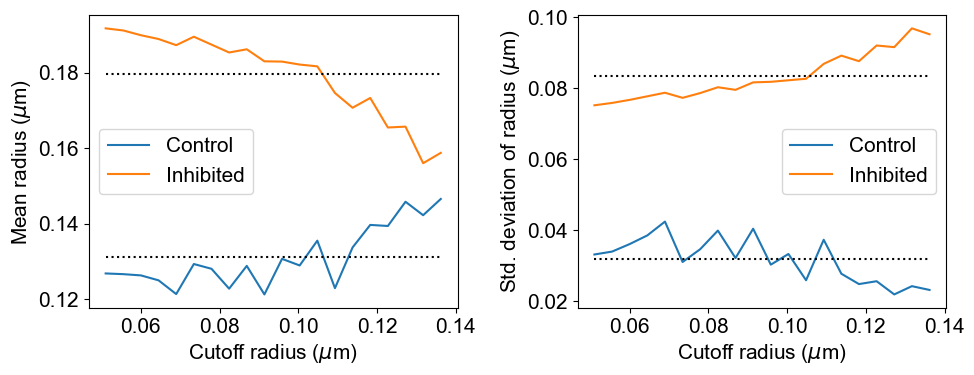

In [58]:
# Plot the above results

print('Control: Mean = ', str(np.mean(mean_dict['Control'])), ' (um), Std. dev = ', str(np.mean(sigma_dict['Control'])))
print('Inhib: Mean = ', str(np.mean(mean_dict['Inhib'])), ' (um), Std. dev = ', str(np.mean(sigma_dict['Inhib'])))

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(cutoff_values_microns, mean_dict['Control'], label='Control')
axs[0].plot(cutoff_values_microns, mean_dict['Inhib'], label='Inhibited')
axs[0].plot(cutoff_values_microns, np.mean(mean_dict['Inhib'])*np.ones(len(cutoff_values_microns)), 
            linestyle=':', c='k')
axs[0].plot(cutoff_values_microns, np.mean(mean_dict['Control'])*np.ones(len(cutoff_values_microns)), 
            linestyle=':', c='k')
axs[0].set_ylabel('Mean radius ($\mu$m)')
axs[0].set_xlabel('Cutoff radius ($\mu$m)')
axs[0].legend()

axs[1].plot(cutoff_values_microns, sigma_dict['Control'], label='Control')
axs[1].plot(cutoff_values_microns, sigma_dict['Inhib'], label='Inhibited')
axs[1].plot(cutoff_values_microns, np.mean(sigma_dict['Inhib'])*np.ones(len(cutoff_values_microns)), 
            linestyle=':', c='k')
axs[1].plot(cutoff_values_microns, np.mean(sigma_dict['Control'])*np.ones(len(cutoff_values_microns)), linestyle=':',
           c='k')
axs[1].set_ylabel('Std. deviation of radius ($\mu$m)')
axs[1].set_xlabel('Cutoff radius ($\mu$m)')
axs[1].legend()
fig.tight_layout()

plt.savefig('Figures_for_paper/Vary_cutoff_size_inhibition.svg', format='svg', dpi=600)
plt.savefig('Figures_for_paper/Vary_cutoff_size_inhibition.pdf', format='pdf', dpi=600)

plt.show()
plt.close()
# fitting_stats.to_csv('Fitting_statistics_size_distbn_fed_starved.csv')

### Fitting droplet spacing distributions

pvalue Normal: KstestResult(statistic=0.03973776864921541, pvalue=2.1562683701010873e-06) pvalue Log Normal: KstestResult(statistic=0.028360230855787982, pvalue=0.0018187406286817962)


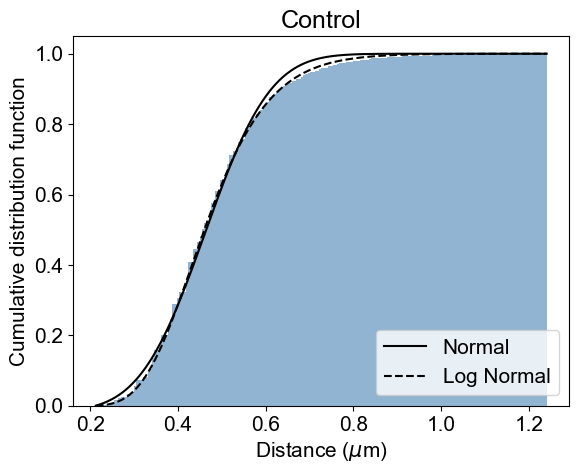

pvalue Normal: KstestResult(statistic=0.08142130001900111, pvalue=9.35241621324853e-05) pvalue Log Normal: KstestResult(statistic=0.05515288372557314, pvalue=0.020447725849260464)


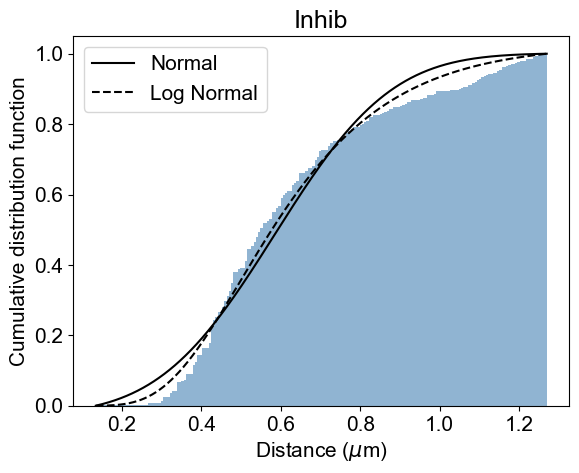

In [578]:
fitting_stats = pd.DataFrame(columns=['Condition', 'KS_Best_Normal', 'pvalue_Best_Normal', 'Mean_Best_Normal (microns)', 
                                      'Std_Best_Normal', 'KS_Best_Log_Normal', 'pvalue_Best_Log_Normal',
                                      'Log_Mean_Best_Log_Normal (microns)', 'Log_Std_Best_Log_Normal (microns)'])
distances = {}

for condition in dataset['sample_type'].unique():
    
    distance_list, fitting_stats_list = fit_distance_distributions(dataset, condition)  
    fitting_stats.loc[len(fitting_stats)] = fitting_stats_list
    distances[condition] = distance_list
    
# fitting_stats.to_csv('Fitting_statistics_spacing_distbn_fed_starved.csv')

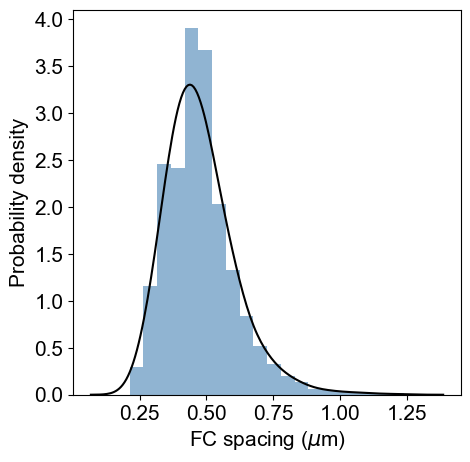

In [69]:
# Plot the spacing distribution for control data

fig, axs = plt.subplots(1, 1, figsize=(5,5))

plt.hist(distances['Control'], bins=20, density=True, 
         cumulative=False, alpha=0.6, color='steelblue', label='Data')
sns.kdeplot(distances['Control'], bw_adjust=2.0, color='k')

plt.ylabel('Probability density')
plt.xlabel('FC spacing ($\mu$m)')
plt.savefig('Figures_for_paper/Droplet_spacing_pdf_control.svg', format='svg', dpi=600)
plt.savefig('Figures_for_paper/Droplet_spacing_pdf_control.pdf', format='pdf', dpi=600)

0.4768927151345971

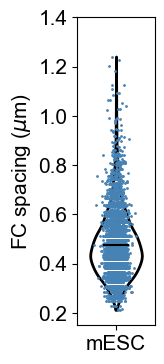

In [579]:
# Plot violin plot of the data

fig, axs = plt.subplots(1, 1, figsize=(1,4))

# Segment the dataset by condition
data = np.array(distances['Control'])

# Plot violinplot
parts = axs.violinplot(data, vert=True, widths=1.0, showmeans=True, showextrema=False)

parts['cmeans'].set_color(['k']*len(data))
for pc in parts['bodies']:
    pc.set_facecolor('white')
    pc.set_edgecolor('black')
    pc.set_alpha(1.0)
    pc.set_linewidth(2.0)
    
# Set the x labels for the plot
def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
labels = ['mESC']
set_axis_style(axs, labels)


# Plot the scatter plot of data
# Add some random "jitter" to the x-axis
x = np.random.normal(1, 0.1, size=len(data))
axs.scatter(x, data, c='steelblue', marker='o', s=1.0, alpha=1.0)

axs.set_ylabel(r'FC spacing ($\mu$m)')
axs.set_ylim([0.15, 1.4])

plt.savefig('Figures_for_paper/Violin_droplet_spacing_mESC.svg', format='svg', dpi=600)
plt.savefig('Figures_for_paper/Violin_droplet_spacing_mESC.pdf', format='pdf', dpi=600)

np.mean(data)

/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Ttest_indResult(statistic=-16.109325586910195, pvalue=6.162655922166009e-51)
0.4768927151345971
0.6227522919431905
0.128859884168242
0.24146200963488906


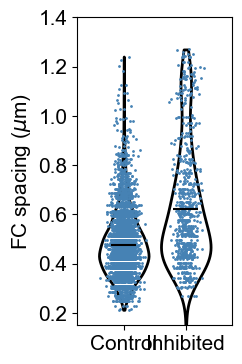

In [584]:
# Violin plots of the spacing distribution

fig, axs = plt.subplots(1, 1, figsize=(2,4))

# Segment the dataset by condition
data = np.array([distances[key] for key in distances.keys()])

# Plot violinplot
parts = axs.violinplot(data, vert=True, widths=0.8, showmeans=True, showextrema=False)

parts['cmeans'].set_color(['k']*len(data))
for pc in parts['bodies']:
    pc.set_facecolor('white')
    pc.set_edgecolor('black')
    pc.set_alpha(1.0)
    pc.set_linewidth(2.0)

# Plot the scatter plot of data
y_list = []
for i in range(len(dataset['sample_type'].unique())):
    condition = dataset['sample_type'].unique()[i]
    y = distances[condition]
    y_list.append(y)
    # Add some random "jitter" to the x-axis
    x = np.random.normal(i+1, 0.1, size=len(y))
    axs.scatter(x, y, color='steelblue', alpha=1.0, s=1.0)
    
# Set the x labels for the plot
def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
labels = ['Control', 'Inhibited']
set_axis_style(axs, labels)

axs.set_ylabel(r'FC spacing ($\mu$m)')
axs.set_ylim([0.15, 1.4])

plt.savefig('Figures_for_paper/Violin_droplet_distances_inhibition.svg', format='svg', dpi=600)
plt.savefig('Figures_for_paper/Violin_droplet_distances_inhibition.pdf', format='pdf', dpi=600)

print(ttest_ind(y_list[0], y_list[1], equal_var=False))

print(np.mean(y_list[0]))
print(np.mean(y_list[1]))

print(np.std(y_list[0]))
print(np.std(y_list[1]))

In [61]:
# Check the whether the fit mean and standard deviation change if we take different amounts of data

cutoff_values = np.linspace(5.0, 8.0, 20)
mean_guess = {'Control': 0.5/micron_per_pixel, 'Inhib': 0.7/micron_per_pixel}

mean_dict = {'Control': [], 'Inhib': []}
sigma_dict = {'Control': [], 'Inhib': []}
pvalue_dict = {'Control': [], 'Inhib': []}

for i in range(len(cutoff_values)):
    print(i)
    for condition in distances.keys():
        data = distances[condition][distances[condition]/micron_per_pixel > cutoff_values[i]]/micron_per_pixel
        rmax = np.max(data)
        exp_log_mean = np.exp(np.mean(np.log(data)))
        exp_log_sigma = np.exp(np.std(np.log(data)))
        # mean = mean_guess[condition]
        # sigma = np.std(data)
        best_log_normal = fit_log_normal(cutoff=cutoff_values[i], 
                                         data=data, rmax=rmax, params_guess=[exp_log_mean, exp_log_sigma])
        r_log_normal, c_log_normal = lognormal(cutoff_values[i], 
                                               rmax, np.log(best_log_normal.x[0]), np.log(best_log_normal.x[1]))
        best_log_normal_cdf = lambda x: log_normal_cdf(r=x, rmin=cutoff_values[i], 
                                                       rmax=rmax, exp_log_mean=best_log_normal.x[0],
                                                       exp_log_sigma=best_log_normal.x[1], dr=0.01)
        best_log_normal_pvalue = kstest(data, best_log_normal_cdf)
        pvalue_dict[condition].append(best_log_normal_pvalue)
        mean_dict[condition].append(best_log_normal.x[0])
        sigma_dict[condition].append(best_log_normal.x[1])
        print(condition, ': ', cutoff_values[i], ',  pvalue: ', best_log_normal_pvalue)
        
        
cutoff_values_microns = np.array(cutoff_values)*micron_per_pixel
mean_dict['Control'] = np.array(mean_dict['Control'])*micron_per_pixel
mean_dict['Inhib'] = np.array(mean_dict['Inhib'])*micron_per_pixel
sigma_dict['Control'] = np.array(sigma_dict['Control'])*micron_per_pixel
sigma_dict['Inhib'] = np.array(sigma_dict['Inhib'])*micron_per_pixel

0
Control :  5.0 ,  pvalue:  KstestResult(statistic=0.028353293747000574, pvalue=0.0018308529057189178)
Inhib :  5.0 ,  pvalue:  KstestResult(statistic=0.054901997186020624, pvalue=0.021572061145719707)
1
Control :  5.157894736842105 ,  pvalue:  KstestResult(statistic=0.028498090182138114, pvalue=0.001709970691415335)
Inhib :  5.157894736842105 ,  pvalue:  KstestResult(statistic=0.05456724927424128, pvalue=0.022789041252640564)
2
Control :  5.315789473684211 ,  pvalue:  KstestResult(statistic=0.028401849608002183, pvalue=0.0017932948832709407)
Inhib :  5.315789473684211 ,  pvalue:  KstestResult(statistic=0.05432752550037395, pvalue=0.02369762749112836)
3
Control :  5.473684210526316 ,  pvalue:  KstestResult(statistic=0.02843245629186031, pvalue=0.0017836176196961337)
Inhib :  5.473684210526316 ,  pvalue:  KstestResult(statistic=0.05422925387572486, pvalue=0.024079287657362114)
4
Control :  5.631578947368421 ,  pvalue:  KstestResult(statistic=0.028470598468348485, pvalue=0.0017503440395

Control: Mean =  0.4605671163952782  (um), Std. dev =  0.054589423663992234
Inhib: Mean =  0.5678368820449369  (um), Std. dev =  0.06639628592767273


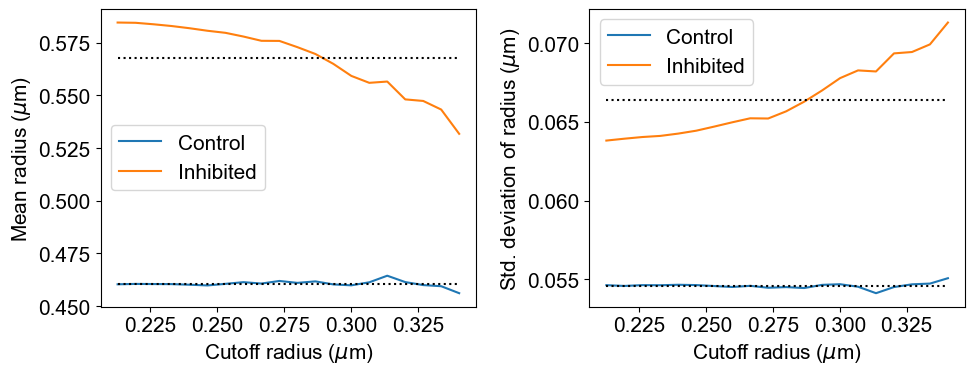

In [62]:
# Plot the above results

print('Control: Mean = ', str(np.mean(mean_dict['Control'])), ' (um), Std. dev = ', str(np.mean(sigma_dict['Control'])))
print('Inhib: Mean = ', str(np.mean(mean_dict['Inhib'])), ' (um), Std. dev = ', str(np.mean(sigma_dict['Inhib'])))

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(cutoff_values_microns, mean_dict['Control'], label='Control')
axs[0].plot(cutoff_values_microns, mean_dict['Inhib'], label='Inhibited')
axs[0].plot(cutoff_values_microns, np.mean(mean_dict['Inhib'])*np.ones(len(cutoff_values_microns)), 
            linestyle=':', c='k')
axs[0].plot(cutoff_values_microns, np.mean(mean_dict['Control'])*np.ones(len(cutoff_values_microns)), 
            linestyle=':', c='k')
axs[0].set_ylabel('Mean radius ($\mu$m)')
axs[0].set_xlabel('Cutoff radius ($\mu$m)')
axs[0].legend()

axs[1].plot(cutoff_values_microns, sigma_dict['Control'], label='Control')
axs[1].plot(cutoff_values_microns, sigma_dict['Inhib'], label='Inhibited')
axs[1].plot(cutoff_values_microns, np.mean(sigma_dict['Inhib'])*np.ones(len(cutoff_values_microns)), 
            linestyle=':', c='k')
axs[1].plot(cutoff_values_microns, np.mean(sigma_dict['Control'])*np.ones(len(cutoff_values_microns)), linestyle=':',
           c='k')
axs[1].set_ylabel('Std. deviation of radius ($\mu$m)')
axs[1].set_xlabel('Cutoff radius ($\mu$m)')
axs[1].legend()
fig.tight_layout()

plt.savefig('Figures_for_paper/Vary_cutoff_distance_inhibition.svg', format='svg', dpi=600)
plt.savefig('Figures_for_paper/Vary_cutoff_distance_inhibition.pdf', format='pdf', dpi=600)

plt.show()
plt.close()
# fitting_stats.to_csv('Fitting_statistics_size_distbn_Control_Inhib.csv')

### Visualizing clusters for control data

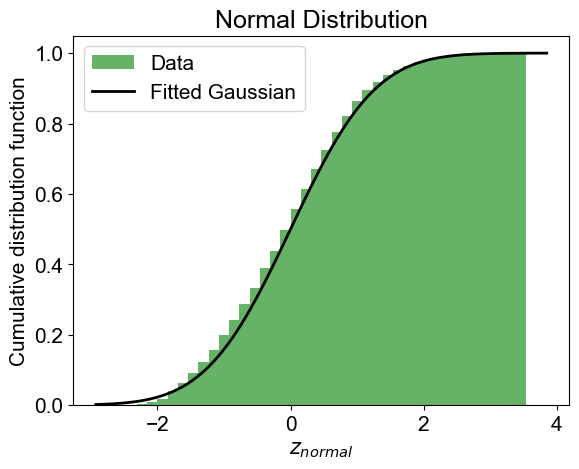

KS Statistic: 0.02400916868086056
P-value: 0.013332870358472504


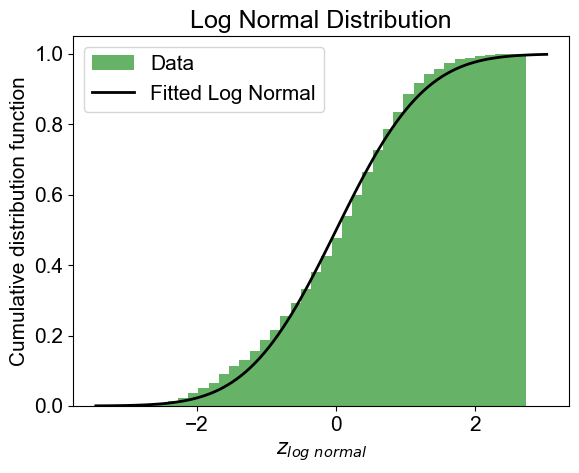

KS Statistic: 0.057393653091382446
P-value: 7.610297602336193e-13


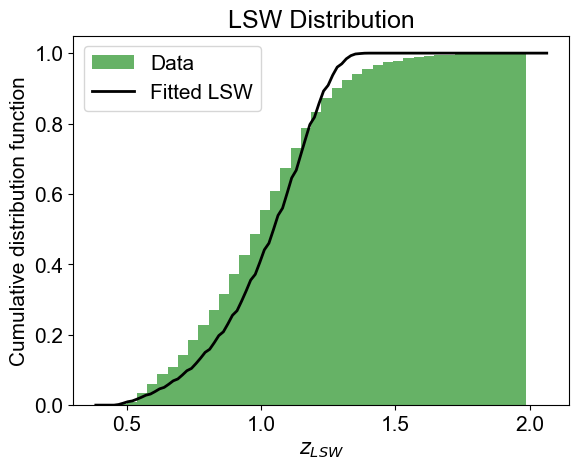

KS Statistic: 0.09474782479000576
P-value: 2.685233074832679e-34


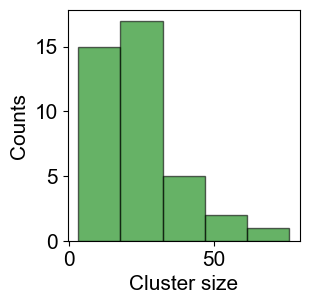

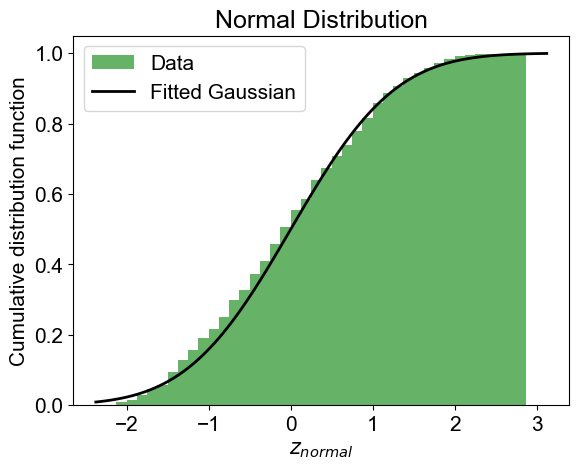

KS Statistic: 0.040320070326212654
P-value: 0.16707630756991865


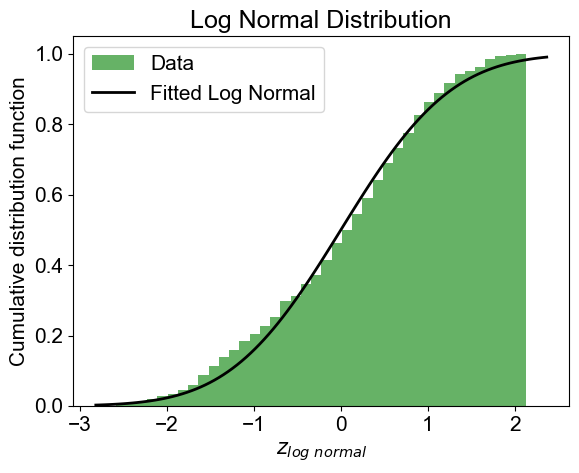

KS Statistic: 0.05861007930071771
P-value: 0.010721936826508164


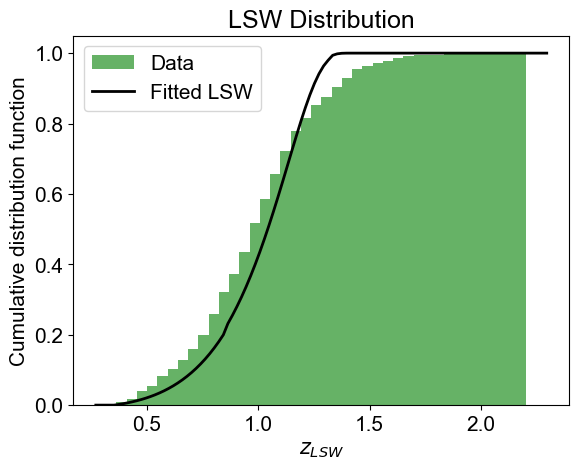

KS Statistic: 0.11543162491943759
P-value: 3.2064850559118985e-09


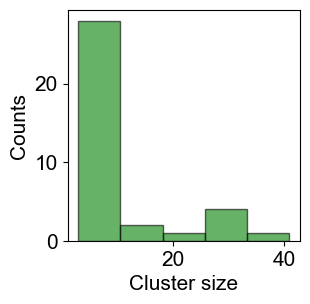

In [582]:
cluster_sizes_list = []

### Clustering performance for the control cells

keys = ['Control-roi-01', 'Control-roi-03', 'Control-roi-05', 'Control-roi-07']

z_values = np.array([], dtype=float)
log_z_values = np.array([], dtype=float)
lsw_norm_values = np.array([], dtype=float)

for key in keys:
    
    points_pixels = np.array([dataset['centroid_r'][dataset['sample']==key], 
                              dataset['centroid_c'][dataset['sample']==key]], dtype=float)
    # Convert x and y coordinate of points from pixels to microns
    points = points_pixels*micron_per_pixel
    # Get the radii of the droplets present at these positions
    radii = np.array(dataset['radius'][dataset['sample']==key], dtype=float)
    z_scores, log_z_scores, lsw_scores, cluster_sizes = cluster_and_get_z_scores(points, radii)
    z_values = np.append(z_values, z_scores)
    lsw_norm_values = np.append(lsw_norm_values, lsw_scores)
    log_z_values = np.append(log_z_values, log_z_scores)
    
fit_z_scores(z_values, log_z_values, lsw_norm_values, figname='Control')

cluster_sizes_list.append(cluster_sizes)

fig,axs = plt.subplots(1,1,figsize=(3,3))
axs.hist(cluster_sizes, bins=5, color='g', edgecolor='k', alpha=0.6)
axs.set_xlabel('Cluster size')
axs.set_ylabel('Counts')
plt.show()
plt.close()

### Clustering performance for the inhibited cells

keys = ['Inhib-roi-01', 'Inhib-roi-03', 'Inhib-roi-05', 'Inhib-roi-07']

z_values = np.array([], dtype=float)
log_z_values = np.array([], dtype=float)
lsw_norm_values = np.array([], dtype=float)

for key in keys:
    
    points_pixels = np.array([dataset['centroid_r'][dataset['sample']==key], 
                              dataset['centroid_c'][dataset['sample']==key]], dtype=float)
    # Convert x and y coordinate of points from pixels to microns
    points = points_pixels*micron_per_pixel
    # Get the radii of the droplets present at these positions
    radii = np.array(dataset['radius'][dataset['sample']==key], dtype=float)
    z_scores, log_z_scores, lsw_scores, cluster_sizes = cluster_and_get_z_scores(points, radii)
    z_values = np.append(z_values, z_scores)
    lsw_norm_values = np.append(lsw_norm_values, lsw_scores)
    log_z_values = np.append(log_z_values, log_z_scores)
    
fit_z_scores(z_values, log_z_values, lsw_norm_values, figname='Inhib')

cluster_sizes_list.append(cluster_sizes)

fig,axs = plt.subplots(1,1,figsize=(3,3))
axs.hist(cluster_sizes, bins=5, color='g', edgecolor='k', alpha=0.6)
axs.set_xlabel('Cluster size')
axs.set_ylabel('Counts')
plt.show()
plt.close()

/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Ttest_indResult(statistic=4.434399348871715, pvalue=3.621777522378544e-05)
22.825
10.083333333333334


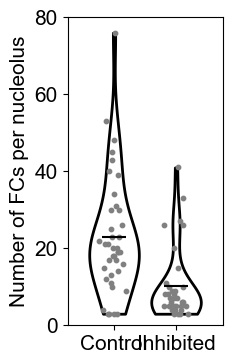

In [587]:
# Violin plots of the spacing distribution

fig, axs = plt.subplots(1, 1, figsize=(2,4))

# Segment the dataset by condition
data = np.array(cluster_sizes_list)

# Plot violinplot
parts = axs.violinplot(data.transpose(), vert=True, widths=0.8, showmeans=True, showextrema=False)

parts['cmeans'].set_color(['k']*len(data))
for pc in parts['bodies']:
    pc.set_facecolor('white')
    pc.set_edgecolor('black')
    pc.set_alpha(1.0)
    pc.set_linewidth(2.0)

# Plot the scatter plot of data
for i in range(2):
    y = data[i]
    # Add some random "jitter" to the x-axis
    x = np.random.normal(i+1, 0.1, size=len(y))
    axs.scatter(x, y, color='grey', alpha=1.0, s=10.0)
    
# Set the x labels for the plot
def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
labels = ['Control', 'Inhibited']
set_axis_style(axs, labels)

axs.set_ylabel(r'Number of FCs per nucleolus')
axs.set_ylim([0, 80])

plt.savefig('Figures_for_paper/Violin_droplet_number_inhibition.svg', format='svg', dpi=600)
plt.savefig('Figures_for_paper/Violin_droplet_number_inhibition.pdf', format='pdf', dpi=600)

print(ttest_ind(data[0], data[1], equal_var=False))

print(np.mean(data[0]))
print(np.mean(data[1]))

/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Ttest_indResult(statistic=4.434399348871715, pvalue=3.621777522378544e-05)

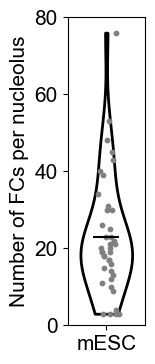

In [585]:
# Violin plots of the spacing distribution

fig, axs = plt.subplots(1, 1, figsize=(1,4))

# Segment the dataset by condition
data = np.array(cluster_sizes_list)

# Plot violinplot
parts = axs.violinplot(data[0], vert=True, widths=1.0, showmeans=True, showextrema=False)

parts['cmeans'].set_color(['k']*len(data))
for pc in parts['bodies']:
    pc.set_facecolor('white')
    pc.set_edgecolor('black')
    pc.set_alpha(1.0)
    pc.set_linewidth(2.0)

# Plot the scatter plot of data
for i in range(1):
    y = data[i]
    # Add some random "jitter" to the x-axis
    x = np.random.normal(i+1, 0.1, size=len(y))
    axs.scatter(x, y, color='grey', alpha=1.0, s=10.0)
    
# Set the x labels for the plot
def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
labels = ['mESC']
set_axis_style(axs, labels)

axs.set_ylabel(r'Number of FCs per nucleolus')
axs.set_ylim([0, 80])

plt.savefig('Figures_for_paper/Violin_droplet_number_mESC.svg', format='svg', dpi=600)
plt.savefig('Figures_for_paper/Violin_droplet_number_mESC.pdf', format='pdf', dpi=600)

ttest_ind(data[0], data[1], equal_var=False)

# Data with mutants

In [586]:
dataset = pd.read_csv('Data/mutation_data.csv')
dataset['radius'] = np.divide(dataset['pixels'], np.pi)**0.5
dataset['radius (microns)'] = dataset['radius']*micron_per_pixel
dataset['sample_type'] = [val[0] for val in dataset['sample'].str.split('-')]
dataset['sample_type'][dataset['sample_type'] == 'dish1'] = 'WT'
dataset['sample_type'][dataset['sample_type'] == 'dish2'] = 'Point mutant'
dataset['sample_type'][dataset['sample_type'] == 'dish3'] = 'Deletion mutant'
dataset.head()

/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import s

,sample,nuc_id,spot_id,pixels,mean_intensity,centroid_r,centroid_c,micron,radius,radius (microns),sample_type
0,dish1-roi-01,2,1,47,0.120563,257,516,0.058536,3.867889,0.164591,WT
1,dish1-roi-01,2,2,42,0.144355,268,501,0.052309,3.656366,0.155590,WT
2,dish1-roi-01,2,3,39,0.115815,267,526,0.048572,3.523363,0.149930,WT
3,dish1-roi-01,2,4,46,0.144417,271,510,0.057290,3.826520,0.162831,WT
4,dish1-roi-01,2,5,47,0.118228,273,537,0.058536,3.867889,0.164591,WT


/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


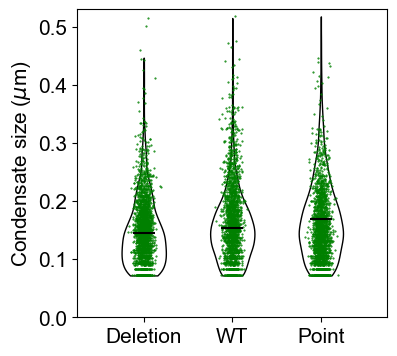

In [16]:
# Plot violin plot of the data

fig, axs = plt.subplots(1, 1, figsize=(4,4))

# Segment the dataset by condition
data = np.array([dataset[dataset['sample_type'] == 'Deletion mutant']['radius (microns)'], 
        dataset[dataset['sample_type'] == 'WT']['radius (microns)'],
                dataset[dataset['sample_type'] == 'Point mutant']['radius (microns)']])

# Plot the scatter plot of data
y_list = []
for i in range(len(dataset['sample_type'].unique())):
    condition = dataset['sample_type'].unique()[i]
    y = dataset[dataset['sample_type'] == condition]['radius (microns)'].dropna()
    y_list.append(y)
    # Add some random "jitter" to the x-axis
    x = np.random.normal(i+1, 0.05, size=len(y))
    axs.plot(x, y, 'go', alpha=1.0, markersize=0.5)

# Plot violinplot
parts = axs.violinplot(data, vert=True, widths=0.5, showmeans=True, showextrema=False)

parts['cmeans'].set_color(['k']*len(data))
for pc in parts['bodies']:
    pc.set_facecolor('white')
    pc.set_edgecolor('black')
    pc.set_alpha(1.0)
    
# Set the x labels for the plot
def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
labels = ['Deletion', 'WT', 'Point']
set_axis_style(axs, labels)

axs.set_ylabel(r'FC size ($\mu$m)')
axs.set_ylim([0.0, 0.53])

plt.savefig('Figures_for_paper/Violin_droplet_size_mutation.svg', format='svg', dpi=600)
plt.savefig('Figures_for_paper/Violin_droplet_size_mutation.pdf', format='pdf', dpi=600)

/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Ttest_indResult(statistic=-7.968419674050518, pvalue=2.1073220462405573e-15)
KstestResult(statistic=0.10707369911590107, pvalue=3.6587399776522034e-11)
0.30606689690531125
0.3368312049867501
0.1107619022697226
0.1383929577764156


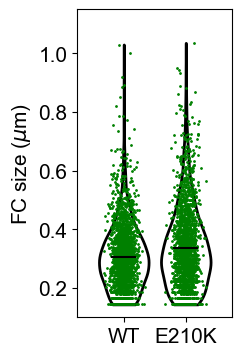

In [589]:
# Plot violin plot of the data

fig, axs = plt.subplots(1, 1, figsize=(2,4))

# Segment the dataset by condition
data = 2.0*np.array([dataset[dataset['sample_type'] == 'WT']['radius (microns)'],
                dataset[dataset['sample_type'] == 'Point mutant']['radius (microns)']])

# Plot violinplot
parts = axs.violinplot(data, vert=True, widths=0.8, showmeans=True, showextrema=False)

parts['cmeans'].set_color(['k']*len(data))
for pc in parts['bodies']:
    pc.set_facecolor('white')
    pc.set_edgecolor('black')
    pc.set_alpha(1.0)
    pc.set_linewidth(2.0)
    
# Set the x labels for the plot
def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
labels = ['WT', 'E210K']
set_axis_style(axs, labels)

# Plot the scatter plot of data
y_list = []
conditions = ['WT', 'Point mutant']
for i in range(len(conditions)):
    condition = conditions[i]
    y = dataset[dataset['sample_type'] == condition]['radius (microns)'].dropna()
    y_list.append(y)
    # Add some random "jitter" to the x-axis
    x = np.random.normal(i+1, 0.1, size=len(y))
    axs.scatter(x, 2.0*y, color='green', marker= 'o', alpha=1.0, s=1.0)

axs.set_ylabel(r'FC size ($\mu$m)')
axs.set_ylim([0.1, 1.15])

plt.savefig('Figures_for_paper/Violin_droplet_size_mutation.svg', format='svg', dpi=600)
plt.savefig('Figures_for_paper/Violin_droplet_size_mutation.pdf', format='pdf', dpi=600)

print(ttest_ind(y_list[0], y_list[1], equal_var=False))
print(ks_2samp(y_list[0], y_list[1]))

print(np.mean(2.0*y_list[0]))
print(np.mean(2.0*y_list[1]))

print(np.std(2.0*y_list[0]))
print(np.std(2.0*y_list[1]))

# print(ttest_ind(y_list[0], y_list[2], equal_var=False))
# print(ks_2samp(y_list[0], y_list[2]))

pvalue Normal: KstestResult(statistic=0.03840454919340669, pvalue=0.0021311833708005453) pvalue Log Normal: KstestResult(statistic=0.03539262708410098, pvalue=0.005968827306883467)


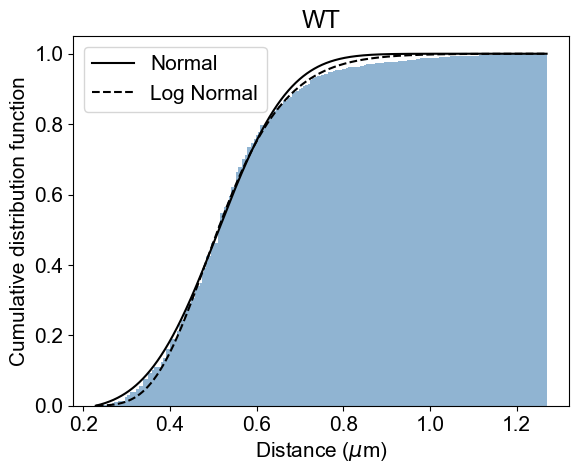

pvalue Normal: KstestResult(statistic=0.04495836563487199, pvalue=0.0007068192866374972) pvalue Log Normal: KstestResult(statistic=0.02769439898918502, pvalue=0.09738357834134281)


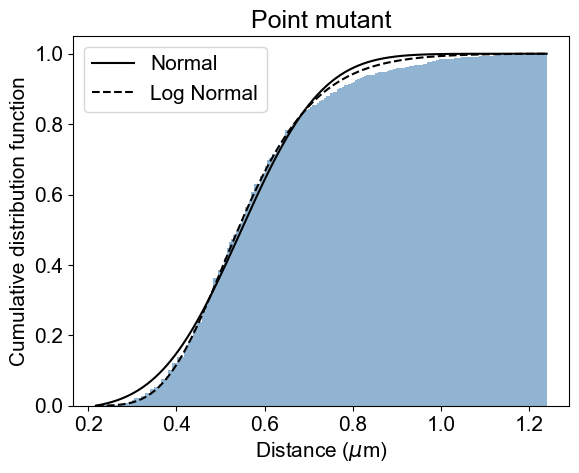

pvalue Normal: KstestResult(statistic=0.049814980866447756, pvalue=2.6408109404812767e-05) pvalue Log Normal: KstestResult(statistic=0.026416994675339867, pvalue=0.08429326472209009)


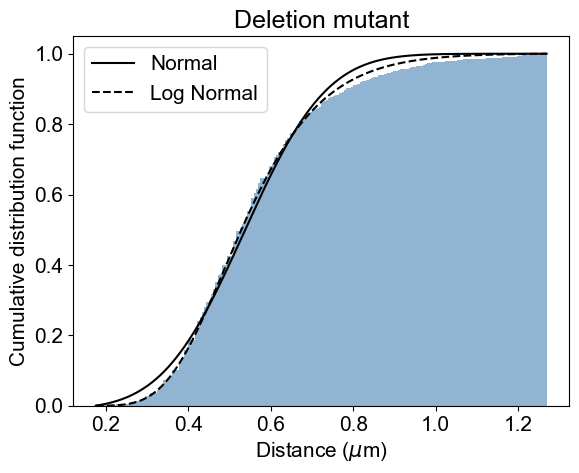

In [590]:
fitting_stats = pd.DataFrame(columns=['Condition', 'KS_Best_Normal', 'pvalue_Best_Normal', 'Mean_Best_Normal (microns)', 
                                      'Std_Best_Normal', 'KS_Best_Log_Normal', 'pvalue_Best_Log_Normal',
                                      'Log_Mean_Best_Log_Normal (microns)', 'Log_Std_Best_Log_Normal (microns)'])
distances = {}

for condition in dataset['sample_type'].unique():
    
    distance_list, fitting_stats_list = fit_distance_distributions(dataset, condition)  
    fitting_stats.loc[len(fitting_stats)] = fitting_stats_list
    distances[condition] = distance_list
    
fitting_stats.to_csv('Fitting_statistics_spacing_distbn_mutation.csv')

/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Ttest_indResult(statistic=-7.656807901807487, pvalue=2.3762459574070208e-14)
KstestResult(statistic=0.11406476729625908, pvalue=1.804667526528192e-12)
0.5284354662816982
0.5641216240161764
0.14348909891728862
0.15832736140927772


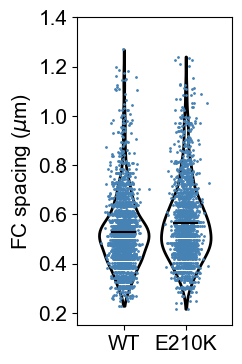

In [593]:
# Violin plots of the spacing distribution

fig, axs = plt.subplots(1, 1, figsize=(2,4))

# Segment the dataset by condition
data = np.array([distances[key] for key in ['WT', 'Point mutant']])

# Plot violinplot
parts = axs.violinplot(data, vert=True, widths=0.8, showmeans=True, showextrema=False)

parts['cmeans'].set_color(['k']*len(data))
for pc in parts['bodies']:
    pc.set_facecolor('white')
    pc.set_edgecolor('black')
    pc.set_alpha(1.0)
    pc.set_linewidth(2.0)

# Plot the scatter plot of data
y_list = []
conditions = ['WT', 'Point mutant']
for i in range(len(conditions)):
    condition = conditions[i]
    y = distances[condition]
    y_list.append(y)
    # Add some random "jitter" to the x-axis
    x = np.random.normal(i+1, 0.1, size=len(y))
    axs.scatter(x, y, color='steelblue', alpha=1.0, s=1.0)
    
# Set the x labels for the plot
def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
labels = ['WT', 'E210K']
set_axis_style(axs, labels)

axs.set_ylabel(r'FC spacing ($\mu$m)')
axs.set_ylim([0.15, 1.4])

plt.savefig('Figures_for_paper/Violin_droplet_distance_mutation.svg', format='svg', dpi=600)
plt.savefig('Figures_for_paper/Violin_droplet_distance_mutation.pdf', format='pdf', dpi=600)

print(ttest_ind(y_list[0], y_list[1], equal_var=False))
print(ks_2samp(y_list[0], y_list[1]))

# print(ttest_ind(y_list[0], y_list[2], equal_var=False))
# print(ks_2samp(y_list[0], y_list[2]))

print(np.mean(y_list[0]))
print(np.mean(y_list[1]))

print(np.std(y_list[0]))
print(np.std(y_list[1]))

In [369]:
dataset['sample'].unique()

array(['dish1-roi-01', 'dish1-roi-02', 'dish1-roi-03', 'dish1-roi-04',
       'dish1-roi-05', 'dish1-roi-06', 'dish2-roi-01', 'dish2-roi-02',
       'dish2-roi-03', 'dish2-roi-04', 'dish2-roi-05', 'dish2-roi-06',
       'dish3-roi-01', 'dish3-roi-02', 'dish3-roi-03', 'dish3-roi-04',
       'dish3-roi-05', 'dish3-roi-06'], dtype=object)

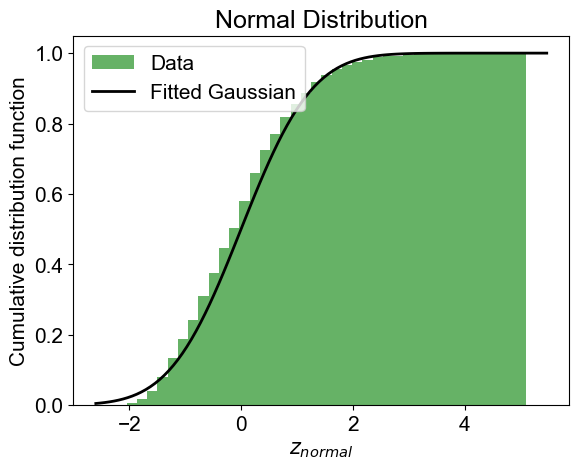

KS Statistic: 0.03677963382892924
P-value: 0.0037333670595037106


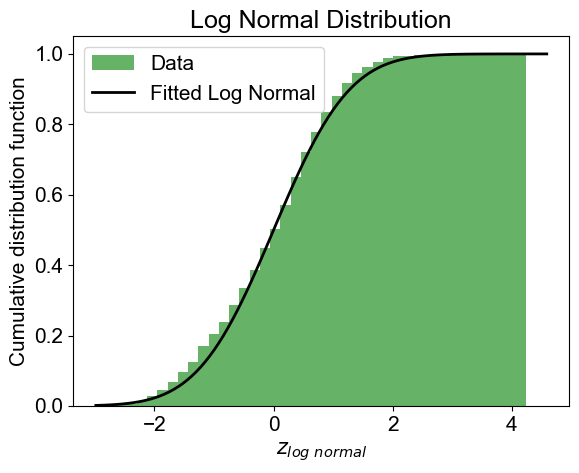

KS Statistic: 0.05088157978389629
P-value: 1.20920569826626e-05


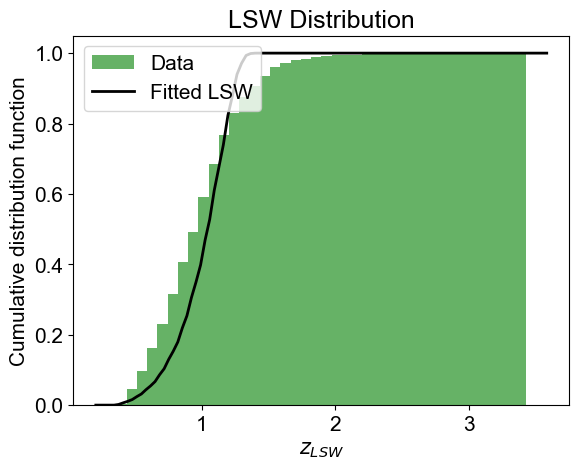

KS Statistic: 0.14520747507334375
P-value: 5.0224045801140425e-43


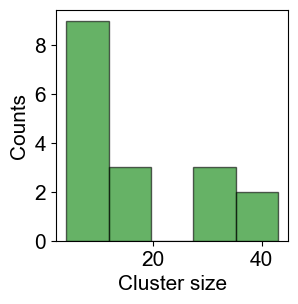

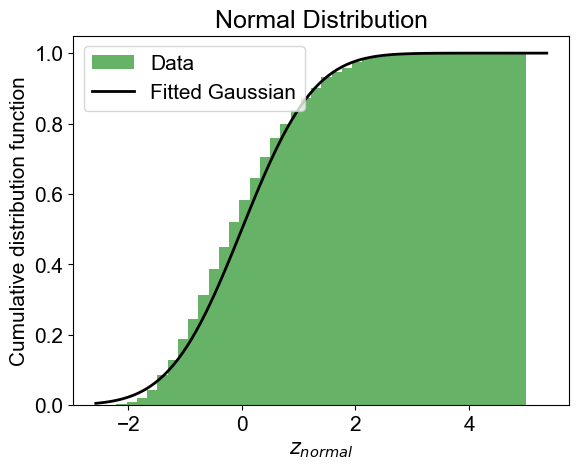

KS Statistic: 0.04593977284956441
P-value: 0.0004834455647619898


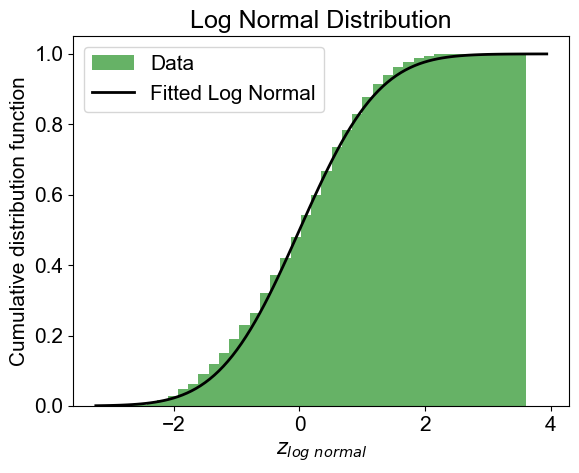

KS Statistic: 0.03552622228110225
P-value: 0.013684686797185108


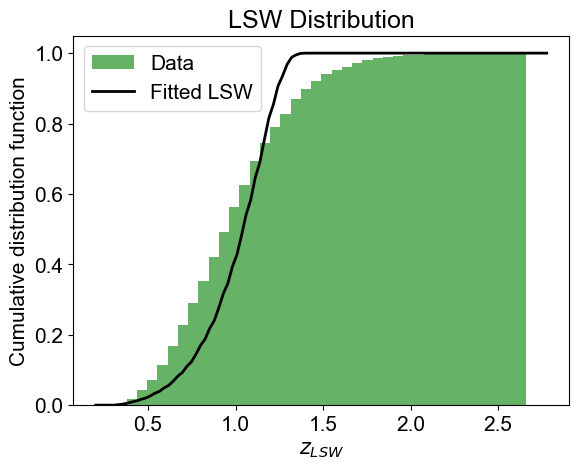

KS Statistic: 0.16043895051261514
P-value: 1.1772169315944872e-44


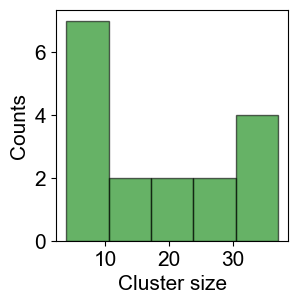

In [594]:
cluster_sizes_list = []

### Clustering performance for the control cells

keys = ['dish1-roi-01', 'dish1-roi-02', 'dish1-roi-03', 'dish1-roi-04',
       'dish1-roi-05', 'dish1-roi-06']

z_values = np.array([], dtype=float)
log_z_values = np.array([], dtype=float)
lsw_norm_values = np.array([], dtype=float)

for key in keys:
    
    points_pixels = np.array([dataset['centroid_r'][dataset['sample']==key], 
                              dataset['centroid_c'][dataset['sample']==key]], dtype=float)
    # Convert x and y coordinate of points from pixels to microns
    points = points_pixels*micron_per_pixel
    # Get the radii of the droplets present at these positions
    radii = np.array(dataset['radius'][dataset['sample']==key], dtype=float)
    z_scores, log_z_scores, lsw_scores, cluster_sizes = cluster_and_get_z_scores(points, radii)
    z_values = np.append(z_values, z_scores)
    lsw_norm_values = np.append(lsw_norm_values, lsw_scores)
    log_z_values = np.append(log_z_values, log_z_scores)
    
fit_z_scores(z_values, log_z_values, lsw_norm_values, figname='WT')

cluster_sizes_list.append(cluster_sizes)

fig,axs = plt.subplots(1,1,figsize=(3,3))
axs.hist(cluster_sizes, bins=5, color='g', edgecolor='k', alpha=0.6)
axs.set_xlabel('Cluster size')
axs.set_ylabel('Counts')
plt.show()
plt.close()

### Clustering performance for the point mutant cells

keys = ['dish2-roi-01', 'dish2-roi-02',
       'dish2-roi-03', 'dish2-roi-04', 'dish2-roi-05', 'dish2-roi-06']

z_values = np.array([], dtype=float)
log_z_values = np.array([], dtype=float)
lsw_norm_values = np.array([], dtype=float)

for key in keys:
    
    points_pixels = np.array([dataset['centroid_r'][dataset['sample']==key], 
                              dataset['centroid_c'][dataset['sample']==key]], dtype=float)
    # Convert x and y coordinate of points from pixels to microns
    points = points_pixels*micron_per_pixel
    # Get the radii of the droplets present at these positions
    radii = np.array(dataset['radius'][dataset['sample']==key], dtype=float)
    z_scores, log_z_scores, lsw_scores, cluster_sizes = cluster_and_get_z_scores(points, radii)
    z_values = np.append(z_values, z_scores)
    lsw_norm_values = np.append(lsw_norm_values, lsw_scores)
    log_z_values = np.append(log_z_values, log_z_scores)
    
fit_z_scores(z_values, log_z_values, lsw_norm_values, figname='Mutant')

cluster_sizes_list.append(cluster_sizes)

fig,axs = plt.subplots(1,1,figsize=(3,3))
axs.hist(cluster_sizes, bins=5, color='g', edgecolor='k', alpha=0.6)
axs.set_xlabel('Cluster size')
axs.set_ylabel('Counts')
plt.show()
plt.close()

### Clustering performance for the deletion mutant cells

# keys = ['dish3-roi-01', 'dish3-roi-02',
#        'dish3-roi-03', 'dish3-roi-04', 'dish3-roi-05', 'dish3-roi-06']

# z_values = np.array([], dtype=float)
# log_z_values = np.array([], dtype=float)
# lsw_norm_values = np.array([], dtype=float)

# for key in keys:
    
#     points_pixels = np.array([dataset['centroid_r'][dataset['sample']==key], 
#                               dataset['centroid_c'][dataset['sample']==key]], dtype=float)
#     # Convert x and y coordinate of points from pixels to microns
#     points = points_pixels*micron_per_pixel
#     # Get the radii of the droplets present at these positions
#     radii = np.array(dataset['radius'][dataset['sample']==key], dtype=float)
#     z_scores, log_z_scores, lsw_scores, cluster_sizes = cluster_and_get_z_scores(points, radii)
#     z_values = np.append(z_values, z_scores)
#     lsw_norm_values = np.append(lsw_norm_values, lsw_scores)
#     log_z_values = np.append(log_z_values, log_z_scores)
    
# fit_z_scores(z_values, log_z_values, lsw_norm_values, figname='Mutant')

# cluster_sizes_list.append(cluster_sizes)

# fig,axs = plt.subplots(1,1,figsize=(3,3))
# axs.hist(cluster_sizes, bins=5, color='g', edgecolor='k', alpha=0.6)
# axs.set_xlabel('Cluster size')
# axs.set_ylabel('Counts')
# plt.show()
# plt.close()

Ttest_indResult(statistic=-0.3158486814286214, pvalue=0.7541708225225078)
KstestResult(statistic=0.17647058823529413, pvalue=0.9631071252458352)
16.88235294117647
18.176470588235293
11.791733659600778
11.382314941417038


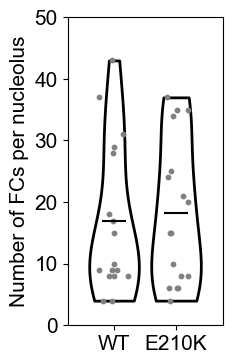

In [596]:
# Violin plots of the spacing distribution

fig, axs = plt.subplots(1, 1, figsize=(2,4))

# Segment the dataset by condition
data = np.array(cluster_sizes_list)

# Plot violinplot
parts = axs.violinplot(data.transpose(), vert=True, widths=0.8, showmeans=True, showextrema=False)

parts['cmeans'].set_color(['k']*len(data))
for pc in parts['bodies']:
    pc.set_facecolor('white')
    pc.set_edgecolor('black')
    pc.set_alpha(1.0)
    pc.set_linewidth(2.0)

# Plot the scatter plot of data
for i in range(2):
    y = data[i]
    # Add some random "jitter" to the x-axis
    x = np.random.normal(i+1, 0.1, size=len(y))
    axs.scatter(x, y, color='grey', alpha=1.0, s=10.0)
    
# Set the x labels for the plot
def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
labels = ['WT', 'E210K']
set_axis_style(axs, labels)

axs.set_ylabel(r'Number of FCs per nucleolus')
axs.set_ylim([0, 50])

plt.savefig('Figures_for_paper/Violin_droplet_number_mutation.svg', format='svg', dpi=600)
plt.savefig('Figures_for_paper/Violin_droplet_number_mutation.pdf', format='pdf', dpi=600)

print(ttest_ind(data[0], data[1], equal_var=False))
print(ks_2samp(data[0], data[1]))

# print(ttest_ind(data[0], data[2], equal_var=False))
# print(ks_2samp(data[0], data[2]))

print(np.mean(data[0]))
print(np.mean(data[1]))

print(np.std(data[0]))
print(np.std(data[1]))

In [391]:
data

array([array([28, 48, 43, 22, 29, 10, 20, 17, 37,  9, 24]),
       array([ 6,  4, 15, 38, 50, 16, 20, 25, 16, 34, 41, 45]),
       array([25, 41, 22, 33, 51, 43, 28, 42, 20, 36, 32, 55, 40, 26, 25,  3, 47])],
      dtype=object)

# Analysis of TCOF overexpression data

In [11]:
dataset = pd.read_csv('Data/TCOF_overexpression_data.csv')
dataset['radius'] = np.divide(dataset['pixels'], np.pi)**0.5
dataset['radius (microns)'] = dataset['radius']*micron_per_pixel
dataset['sample_type'] = ['Control' if val[2] == 'dox_nega' else 'Overexpression' 
                          for val in dataset['sample'].str.split('-')]
dataset.head()

,sample,nuc_id,spot_id,pixels,mean_intensity,centroid_r,centroid_c,radius,radius (microns),sample_type
0,dish1-647FIB1-dox_nega-01,-1,1,74,0.003137,2,200,4.853342,0.206525,Control
1,dish1-647FIB1-dox_nega-01,-1,2,26,0.007053,1,975,2.876814,0.122418,Control
2,dish1-647FIB1-dox_nega-01,-1,3,38,0.005438,2,1024,3.477898,0.147996,Control
3,dish1-647FIB1-dox_nega-01,-1,4,30,0.003389,2,1298,3.090194,0.131498,Control
4,dish1-647FIB1-dox_nega-01,-1,5,116,0.004051,4,1329,6.076508,0.258575,Control


### Distance between FCs

/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Ttest_indResult(statistic=-32.98948434561646, pvalue=9.1196200868707e-185)
0.3846949886088369
0.7507350376497012
0.1351133458025056
0.4193329636246764


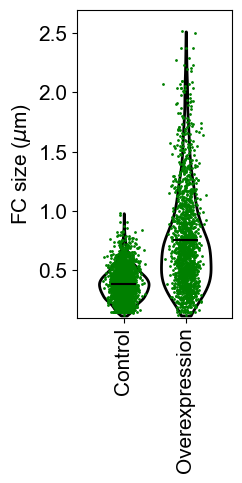

In [51]:
# Plot violin plot of the data

fig, axs = plt.subplots(1, 1, figsize=(2,4))

# Segment the dataset by condition
data = 2.0*np.array([dataset[dataset['sample_type'] == 'Control']['radius (microns)'], 
                     dataset[dataset['sample_type'] == 'Overexpression']['radius (microns)']])

# Plot violinplot
parts = axs.violinplot(data, vert=True, widths=0.8, showmeans=True, showextrema=False)

parts['cmeans'].set_color(['k']*len(data))
for pc in parts['bodies']:
    pc.set_facecolor('white')
    pc.set_edgecolor('black')
    pc.set_alpha(1.0)
    pc.set_linewidth(2.0)
    
# Set the x labels for the plot
def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
labels = ['Control', 'Overexpression']
set_axis_style(axs, labels)

# Plot the scatter plot of data
y_list = []
i = 0
for condition in ['Control', 'Overexpression']:
    # condition = dataset['sample_type'].unique()[i]
    y = 2.0*dataset[dataset['sample_type'] == condition]['radius (microns)'].dropna()
    y_list.append(y)
    # Add some random "jitter" to the x-axis
    x = np.random.normal(i+1, 0.1, size=len(y))
    axs.scatter(x, y, color='green', marker='o', alpha=1.0, s=1.0)
    i = i+1

axs.set_ylabel(r'FC size ($\mu$m)')
axs.set_ylim([0.1, 2.7])
axs.tick_params(axis='x', labelrotation=90)

plt.savefig('Figures_for_paper/Violin_droplet_size_TCOF_overexpression.svg', format='svg', dpi=600)
plt.savefig('Figures_for_paper/Violin_droplet_size_TCOF_overexpression.pdf', format='pdf', dpi=600)

print(ttest_ind(y_list[0], y_list[1], equal_var=False))

print(np.mean(y_list[0]))
print(np.mean(y_list[1]))

print(np.std(y_list[0]))
print(np.std(y_list[1]))

### Spacing between FCs

pvalue Normal: KstestResult(statistic=0.05615433462950094, pvalue=1.0588838888440222e-07) pvalue Log Normal: KstestResult(statistic=0.034841586218412865, pvalue=0.0031425574792610994)


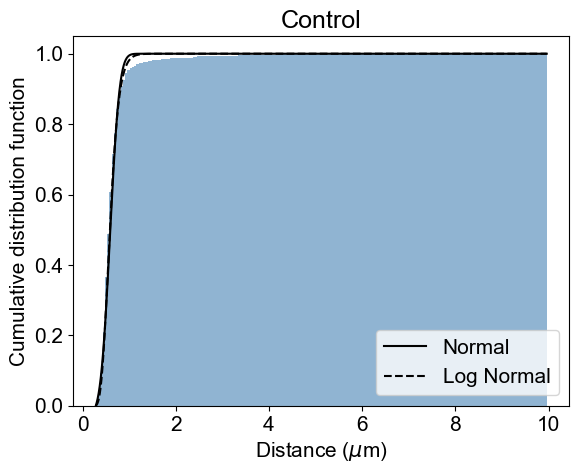

pvalue Normal: KstestResult(statistic=0.04663762471567512, pvalue=0.0026683661123777396) pvalue Log Normal: KstestResult(statistic=0.027730990416251343, pvalue=0.19112518097184128)


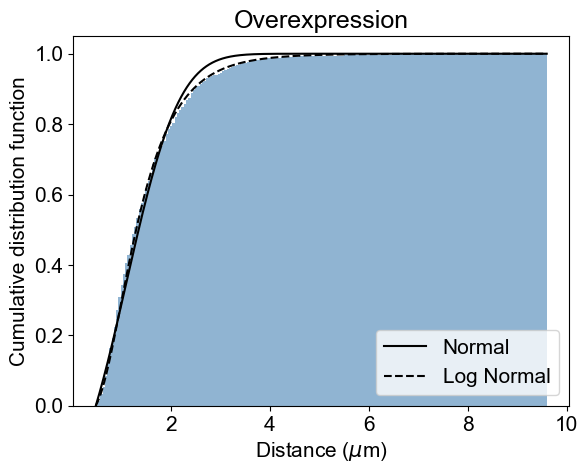

In [56]:
# Get distances between FCs and fit a distance distribution

fitting_stats = pd.DataFrame(columns=['Condition', 'KS_Best_Normal', 'pvalue_Best_Normal', 'Mean_Best_Normal (microns)', 
                                      'Std_Best_Normal', 'KS_Best_Log_Normal', 'pvalue_Best_Log_Normal',
                                      'Log_Mean_Best_Log_Normal (microns)', 'Log_Std_Best_Log_Normal (microns)'])
distances = {}

for condition in dataset['sample_type'].unique():
    
    distance_list, fitting_stats_list = fit_distance_distributions(dataset, condition)  
    fitting_stats.loc[len(fitting_stats)] = fitting_stats_list
    distances[condition] = distance_list
    
fitting_stats.to_csv('Fitting_statistics_spacing_distbn_TCOF_overexpression.csv')

/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == "__main__":


Ttest_indResult(statistic=-36.50768468516809, pvalue=4.854391369457723e-223)
0.6522087670675515
1.5092437325818944
0.429219212389429
0.8535495178726042


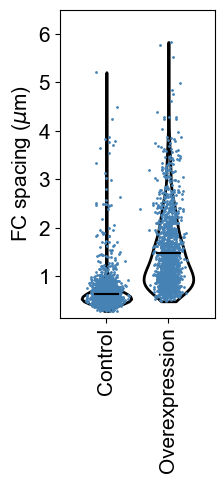

In [74]:
# Violin plots of the spacing distribution

fig, axs = plt.subplots(1, 1, figsize=(2,4))

# Segment the dataset by condition
data = np.array([distances[key] for key in ['Control', 'Overexpression']])

# Distances above 6 microns are rare, so chuck that. Otherwise, you get a very long tail
data = np.array([data_array[data_array < 6.0] for data_array in data])

# Set the x labels for the plot
def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
labels = ['Control', 'Overexpression']
set_axis_style(axs, labels)

# Plot violinplot
parts = axs.violinplot(data, vert=True, widths=0.8, showmeans=True, showextrema=False)

parts['cmeans'].set_color(['k']*len(data))
for pc in parts['bodies']:
    pc.set_facecolor('white')
    pc.set_edgecolor('black')
    pc.set_alpha(1.0)
    pc.set_linewidth(2.0)

# Plot the scatter plot of data
y_list = []
i = 0
for condition in ['Control', 'Overexpression']:
    # condition = dataset['sample_type'].unique()[i]
    y = distances[condition]
    y_list.append(y)
    # Add some random "jitter" to the x-axis
    y = np.array(y)
    # Distances above 6 microns are rare, so chuck that. Otherwise, you get a very long tail
    y = y[y < 6.0]
    x = np.random.normal(i+1, 0.1, size=len(y))
    axs.scatter(x, y, color='steelblue', alpha=1.0, s=1.0)
    i = i+1
    
    
axs.set_ylabel(r'FC spacing ($\mu$m)')
axs.set_ylim([0.15, 6.5])
axs.tick_params(axis='x', labelrotation=90)

plt.savefig('Figures_for_paper/Violin_droplet_distance_TCOF_overexpression.svg', format='svg', dpi=600)
plt.savefig('Figures_for_paper/Violin_droplet_distance_TCOF_overexpression.pdf', format='pdf', dpi=600)

print(ttest_ind(y_list[0], y_list[1], equal_var=False))

print(np.mean(y_list[0]))
print(np.mean(y_list[1]))

print(np.std(y_list[0]))
print(np.std(y_list[1]))

### Get number of FCs

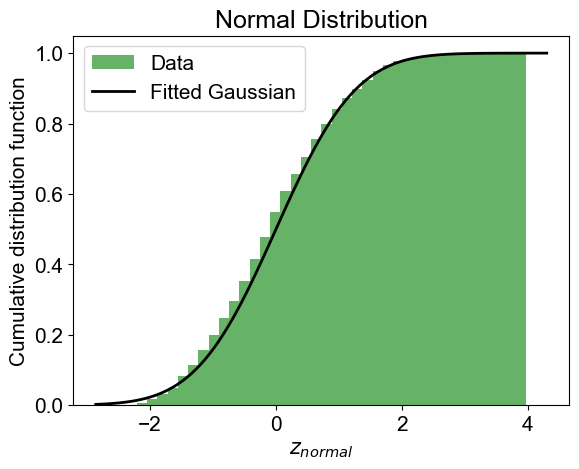

KS Statistic: 0.024699041257669863
P-value: 0.08446889425916204


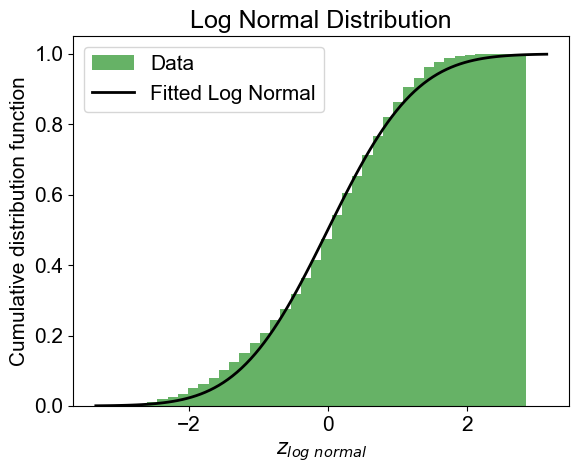

KS Statistic: 0.05114455815720448
P-value: 2.639238031069213e-06


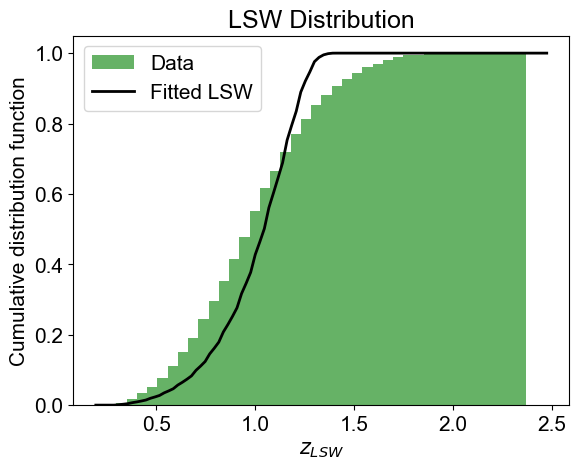

KS Statistic: 0.15018563841549926
P-value: 2.875575497097041e-51


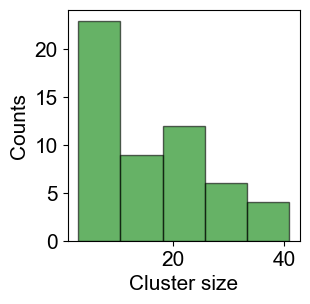

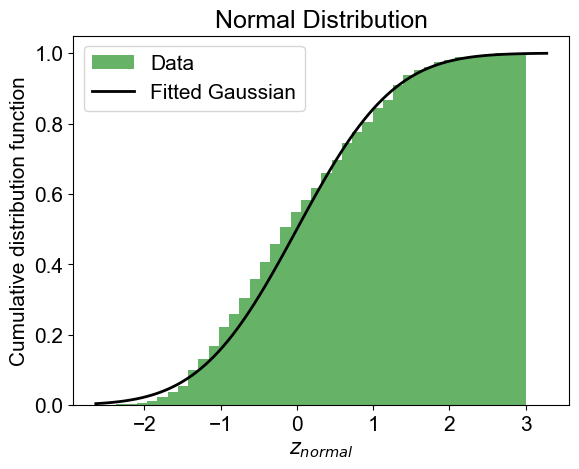

KS Statistic: 0.05075999706339668
P-value: 0.009314872788341632


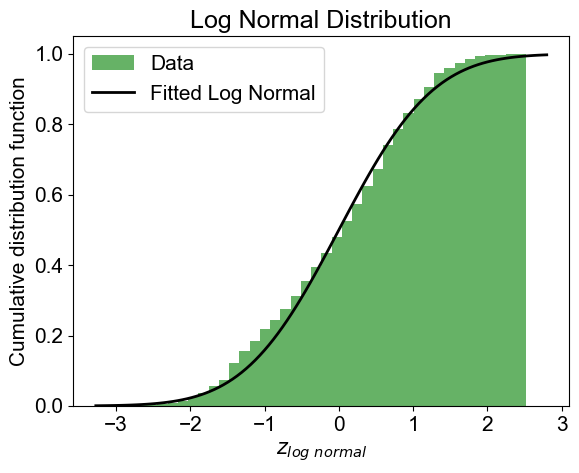

KS Statistic: 0.06132400803269522
P-value: 0.0007950259838695911


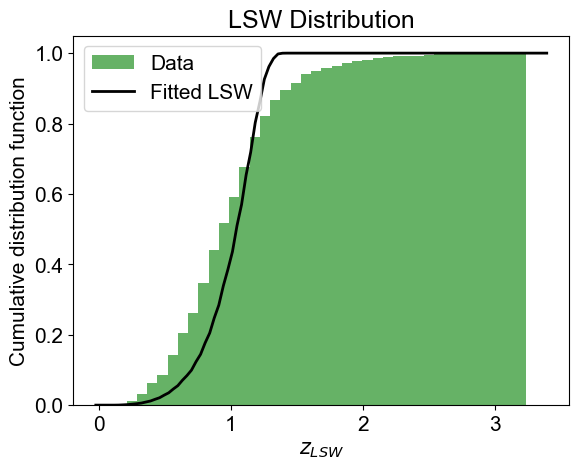

KS Statistic: 0.1608628555616696
P-value: 7.252223840725532e-24


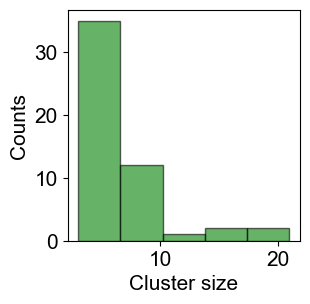

In [45]:
cluster_sizes_list = []

### Clustering points and plotting normalized size distribution for control

keys = ['dish1-647FIB1-dox_nega-01', 'dish1-647FIB1-dox_nega-02', 'dish1-647FIB1-dox_nega-03']

z_values = np.array([], dtype=float)
log_z_values = np.array([], dtype=float)
lsw_norm_values = np.array([], dtype=float)

for key in keys:
    
    points_pixels = np.array([dataset['centroid_r'][dataset['sample']==key], 
                              dataset['centroid_c'][dataset['sample']==key]], dtype=float)
    # Convert x and y coordinate of points from pixels to microns
    points = points_pixels*micron_per_pixel
    # Get the radii of the droplets present at these positions
    radii = np.array(dataset['radius'][dataset['sample']==key], dtype=float)
    z_scores, log_z_scores, lsw_scores, cluster_sizes = cluster_and_get_z_scores(points, radii)
    z_values = np.append(z_values, z_scores)
    lsw_norm_values = np.append(lsw_norm_values, lsw_scores)
    log_z_values = np.append(log_z_values, log_z_scores)
    
fit_z_scores(z_values, log_z_values, lsw_norm_values, figname='Control_TCOF')

cluster_sizes_list.append(cluster_sizes)

fig,axs = plt.subplots(1,1,figsize=(3,3))
axs.hist(cluster_sizes, bins=5, edgecolor='k', color='g', alpha=0.6)
axs.set_xlabel('Cluster size')
axs.set_ylabel('Counts')
plt.show()
plt.close()

### Clustering points and plotting normalized size distribution for fed cells

keys = ['dish2-647FIB1-dox_posi-01', 'dish2-647FIB1-dox_posi-02', 'dish2-647FIB1-dox_posi-03', 
        'dish2-647FIB1-dox_posi-04']

z_values = np.array([], dtype=float)
log_z_values = np.array([], dtype=float)
lsw_norm_values = np.array([], dtype=float)

for key in keys:
    
    points_pixels = np.array([dataset['centroid_r'][dataset['sample']==key], 
                              dataset['centroid_c'][dataset['sample']==key]], dtype=float)
    # Convert x and y coordinate of points from pixels to microns
    points = points_pixels*micron_per_pixel
    # Get the radii of the droplets present at these positions
    radii = np.array(dataset['radius'][dataset['sample']==key], dtype=float)
    z_scores, log_z_scores, lsw_scores, cluster_sizes = cluster_and_get_z_scores(points, radii)
    z_values = np.append(z_values, z_scores)
    lsw_norm_values = np.append(lsw_norm_values, lsw_scores)
    log_z_values = np.append(log_z_values, log_z_scores)
    
fit_z_scores(z_values, log_z_values, lsw_norm_values, figname='Overexpress_TCOF')

cluster_sizes_list.append(cluster_sizes)

fig,axs = plt.subplots(1,1,figsize=(3,3))
axs.hist(cluster_sizes, bins=5, color='g', edgecolor='k', alpha=0.6)
axs.set_xlabel('Cluster size')
axs.set_ylabel('Counts')
plt.show()
plt.close()

/home/npradeep96/miniconda3/envs/IDRBlocks/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Ttest_indResult(statistic=5.69914429163071, pvalue=2.835425811489168e-07)
15.092592592592593
6.230769230769231


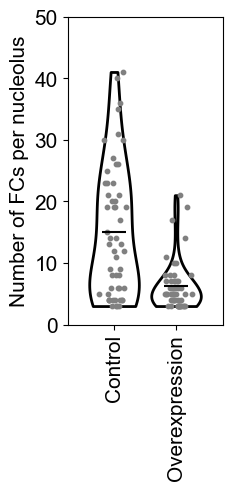

In [73]:
# Violin plots of the spacing distribution

fig, axs = plt.subplots(1, 1, figsize=(2,4))

# Segment the dataset by condition
data = np.array(cluster_sizes_list)

# Plot violinplot
parts = axs.violinplot(data, vert=True, widths=0.8, showmeans=True, showextrema=False)

parts['cmeans'].set_color(['k']*len(data))
for pc in parts['bodies']:
    pc.set_facecolor('white')
    pc.set_edgecolor('black')
    pc.set_alpha(1.0)
    pc.set_linewidth(2.0)

# Plot the scatter plot of data
for i in range(2):
    y = data[i]
    # Add some random "jitter" to the x-axis
    x = np.random.normal(i+1, 0.1, size=len(y))
    axs.scatter(x, y, color='grey', alpha=1.0, s=10.0)
    
# Set the x labels for the plot
def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
labels = ['Control', 'Overexpression']
set_axis_style(axs, labels)

axs.set_ylabel(r'Number of FCs per nucleolus')
axs.set_ylim([0, 50])
axs.tick_params(axis='x', labelrotation=90)

plt.savefig('Figures_for_paper/Violin_droplet_number_TCOF_overexpression.svg', format='svg', dpi=600)
plt.savefig('Figures_for_paper/Violin_droplet_number_TCOF_overexpression.pdf', format='pdf', dpi=600)

print(ttest_ind(data[0], data[1], equal_var=False))

print(np.mean(data[0]))
print(np.mean(data[1]))